# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.calibration import calibration_curve

from sklearn.metrics import (
    roc_auc_score, balanced_accuracy_score, 
    confusion_matrix, precision_score, recall_score, log_loss, brier_score_loss, balanced_accuracy_score, f1_score
)

from scipy.stats import ks_2samp

from mapie.metrics.calibration import expected_calibration_error

# Helper Functions

In [2]:
# Model Metric
def model_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)

    metrics = {
        "ROC_AUC": round(roc_auc_score(y_true, y_prob), 3),
        "Balanced_Accuracy": round(balanced_accuracy_score(y_true, y_pred), 3),
        "Precision": round(precision_score(y_true, y_pred, zero_division=0), 3),
        "Recall": round(recall_score(y_true, y_pred, zero_division=0), 3),
        "F1": round(f1_score(y_true, y_pred, zero_division=0), 3),
        "LogLoss": round(log_loss(y_true, y_prob), 3),
    }

    return metrics


def get_model_performance(df, additional_prob=None):
    model_perf = pd.DataFrame()

    for nodes in ['lr', 'xgb']:
        for models in ['raw_prob', 'platt_prob', 'iso_prob', 'venn_ivap', 'venn_cvap']:
            performance = model_metrics(df['loan_status'], df[f'{nodes}_{models}'], threshold=0.17)
            performance['method_name'] = f'{nodes}_{models}'
            performance = pd.DataFrame([performance])
            model_perf = pd.concat([model_perf, performance], ignore_index=True)

    if additional_prob is not None:
        performance = model_metrics(df['loan_status'], df[additional_prob], threshold=0.17)
        performance['method_name'] = additional_prob
        performance = pd.DataFrame([performance])
        model_perf = pd.concat([model_perf, performance], ignore_index=True)

    return model_perf


#######################################################

# Calibration Metrics
def calibration_metrics(y_true, y_proba, method_name, split_strategy='uniform'):
    logloss = round(log_loss(y_true, y_proba),3)
    brier   = round(brier_score_loss(y_true, y_proba),3)
    ece = round(expected_calibration_error(y_true, y_proba, num_bins=10, split_strategy=split_strategy),3)
    return {"Method": method_name, "Log Loss": logloss, "Brier Score": brier, "ECE": ece}

def get_calibration_performance(df, split_strategy='quantile', additional_prob=None):
    calib_perf = pd.DataFrame()

    for nodes in ['lr', 'xgb']:
        for models in ['raw_prob', 'platt_prob', 'iso_prob', 'venn_ivap', 'venn_cvap']:
            performance = calibration_metrics(df['loan_status'], df[f'{nodes}_{models}'], method_name=f'{nodes}_{models}', split_strategy=split_strategy)
            performance = pd.DataFrame([performance])
            calib_perf = pd.concat([calib_perf, performance], ignore_index=True)

    if additional_prob is not None:
        performance = calibration_metrics(df['loan_status'], df[additional_prob], method_name=additional_prob, split_strategy=split_strategy)
        performance = pd.DataFrame([performance])
        calib_perf = pd.concat([calib_perf, performance], ignore_index=True)

    return calib_perf

In [3]:
def model_performance_plot(df, prob_name, model_name, set):

    train = df.copy()
    train['bin'] = pd.qcut(train[prob_name], q=10, labels=False, duplicates='drop')

    train_grp = train.groupby('bin').agg(
        count=('loan_status', 'size'),
        pos=('loan_status', 'sum'),
        neg=('loan_status', lambda x: (x == 0).sum())
    ).reset_index()


    train_grp['% pos'] = round(train_grp['pos'] / train_grp['count'] * 100,1)
    train_grp['% dist pos'] = round(train_grp['pos'] / train_grp['pos'].sum() * 100,1)
    train_grp['% dist neg'] = round(train_grp['neg'] / train_grp['neg'].sum() * 100,1)

    # Width of each bar
    bar_width = 0.35

    # Create figure and axis objects
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot mean values on the first y-axis
    ax1.plot(train_grp['bin'], train_grp['% pos'],'--o', color='gray', label='Default Rate')
    ax1.set_xlabel('Riskiness')
    ax1.set_ylabel('% Default Rate', color='gray')
    # ax1.set_ylim(top=100)
    ax1.tick_params('y', colors='gray')

    # Create a second y-axis sharing the same x-axis
    ax2 = ax1.twinx()

    # Plot sum and count values on the second y-axis as separate bars
    index = np.arange(len(train_grp['bin']))
    ax2.set_xticks(index)
    ax2.bar(index - bar_width/2, train_grp['% dist neg'], bar_width, color='lightcoral', alpha=0.5, label='Non-Default')
    ax2.bar(index + bar_width/2, train_grp['% dist pos'], bar_width, color='olivedrab', alpha=0.5, label='Default')
    ax2.set_ylabel('%N of Default and Non-Default', color='lightcoral')
    # ax2.set_ylim(top=50)
    ax2.tick_params('y', colors='lightcoral')

    # Rotate x-axis tick labels

    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    # Show plot
    plt.title(f'**{model_name}** Default and Non-Default Distribution ({set} Set)')
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

    return train_grp

In [4]:
def plot_ks_and_cdf(df, prob_col, label='Raw Probability', model_name='Model'):
    # Split probabilities by class
    prob_0 = df[df['loan_status'] == 0][prob_col]
    prob_1 = df[df['loan_status'] == 1][prob_col]

    # KS statistic
    ks_stat, ks_p = ks_2samp(prob_0, prob_1)
    print(f"KS Statistic ({model_name}): {ks_stat:.4f}, p-value: {ks_p:.4g}")

    # Plot PDFs (histograms)
    plt.figure(figsize=(14, 6)) # Adjusted figure size for better layout
    plt.subplot(1, 2, 1)
    plt.hist(prob_0, bins=50, alpha=0.6, label='Non-Default (0)', density=True, color='skyblue')
    plt.hist(prob_1, bins=50, alpha=0.6, label='Default (1)', density=True, color='salmon')
    plt.title(f'{model_name} - PDF {label}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.legend()

    # Plot CDFs
    plt.subplot(1, 2, 2)
    prob_0_sorted = np.sort(prob_0)
    prob_1_sorted = np.sort(prob_1)
    cdf_0 = np.arange(1, len(prob_0_sorted)+1) / len(prob_0_sorted)
    cdf_1 = np.arange(1, len(prob_1_sorted)+1) / len(prob_1_sorted)
    plt.plot(prob_0_sorted, cdf_0, label='Non-Default (0)', color='skyblue')
    plt.plot(prob_1_sorted, cdf_1, label='Default (1)', color='salmon')
    
    # --- START OF CORRECTED SECTION ---
    
    # Find the probability (x-value) where the maximum difference occurs
    all_probs = np.unique(np.concatenate([prob_0, prob_1]))
    cdf_0_vals = np.array([np.mean(prob_0 <= x) for x in all_probs])
    cdf_1_vals = np.array([np.mean(prob_1 <= x) for x in all_probs])
    diffs = np.abs(cdf_0_vals - cdf_1_vals)
    
    # Get the location and values for the KS line
    max_diff_idx = np.argmax(diffs)
    ks_location = all_probs[max_diff_idx]
    cdf_0_at_ks = cdf_0_vals[max_diff_idx]
    cdf_1_at_ks = cdf_1_vals[max_diff_idx]

    # Plot the vertical line at the correct location
    plt.axvline(x=ks_location, color='gray', linestyle='--', label=f'KS location: {ks_location:.4f}')
    
    # Plot the vertical line segment representing the KS statistic
    plt.plot([ks_location, ks_location], [cdf_0_at_ks, cdf_1_at_ks], 
             color='black', linewidth=2, label=f'KS Statistic: {ks_stat:.4f}')
             

    plt.title(f'{model_name} - CDF {label}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    # plt.grid(True)

    plt.tight_layout()
    plt.show()

    return ks_stat, ks_p

# Import Data

`XGBoost`

In [5]:
xgb_train = pd.read_csv("Results/prob_tr_xgb.csv", low_memory=False)
xgb_valid = pd.read_csv("Results/prob_val_xgb.csv", low_memory=False)
xgb_test = pd.read_csv("Results/prob_test_xgb.csv", low_memory=False)

In [6]:
xgb_train.columns

Index(['ID', 'Raw (Uncalibrated)', 'Platt Scaling', 'Isotonic Regression',
       'Venn-Abers (IVAP)', 'P0 (IVAP)', 'P1 (IVAP)', 'Venn-Abers (CVAP)',
       'Mean P0 (CVAP)', 'Mean P1 (CVAP)', 'Min P0 (CVAP)', 'Max P1 (CVAP)',
       'loan_status'],
      dtype='object')

In [7]:
xgb_train.rename(columns={'Raw (Uncalibrated)': 'xgb_raw_prob', 'Platt Scaling': 'xgb_platt_prob', 'Isotonic Regression': 'xgb_iso_prob',
                          'Venn-Abers (IVAP)': 'xgb_venn_ivap', 'P0 (IVAP)': 'xgb_p0_ivap', 'P1 (IVAP)': 'xgb_p1_ivap',
                          'Venn-Abers (CVAP)': 'xgb_venn_cvap', 'Mean P0 (CVAP)': 'xgb_mean_p0_cvap', 'Mean P1 (CVAP)': 'xgb_mean_p1_cvap',
                          'Min P0 (CVAP)': 'xgb_min_p0_cvap', 'Max P1 (CVAP)': 'xgb_max_p1_cvap'}, inplace=True)

xgb_valid.rename(columns={'Raw (Uncalibrated)': 'xgb_raw_prob', 'Platt Scaling': 'xgb_platt_prob', 'Isotonic Regression': 'xgb_iso_prob',
                          'Venn-Abers (IVAP)': 'xgb_venn_ivap', 'P0 (IVAP)': 'xgb_p0_ivap', 'P1 (IVAP)': 'xgb_p1_ivap',
                          'Venn-Abers (CVAP)': 'xgb_venn_cvap', 'Mean P0 (CVAP)': 'xgb_mean_p0_cvap', 'Mean P1 (CVAP)': 'xgb_mean_p1_cvap',
                          'Min P0 (CVAP)': 'xgb_min_p0_cvap', 'Max P1 (CVAP)': 'xgb_max_p1_cvap'}, inplace=True)

xgb_test.rename(columns={'Raw (Uncalibrated)': 'xgb_raw_prob', 'Platt Scaling': 'xgb_platt_prob', 'Isotonic Regression': 'xgb_iso_prob',
                          'Venn-Abers (IVAP)': 'xgb_venn_ivap', 'P0 (IVAP)': 'xgb_p0_ivap', 'P1 (IVAP)': 'xgb_p1_ivap',
                          'Venn-Abers (CVAP)': 'xgb_venn_cvap', 'Mean P0 (CVAP)': 'xgb_mean_p0_cvap', 'Mean P1 (CVAP)': 'xgb_mean_p1_cvap',
                          'Min P0 (CVAP)': 'xgb_min_p0_cvap', 'Max P1 (CVAP)': 'xgb_max_p1_cvap'}, inplace=True)

In [8]:
xgb_train.head()

ID  xgb_raw_prob  xgb_platt_prob  xgb_iso_prob  xgb_venn_ivap  \
0  23482      0.056485        0.045133      0.044118       0.046784   
1  14094      0.926562        0.992440      0.982456       0.958497   
2   3966      0.045211        0.040906      0.023256       0.024956   
3   5052      0.004552        0.028603      0.000000       0.001161   
4  25312      0.135356        0.088411      0.114458       0.116000   

   xgb_p0_ivap  xgb_p1_ivap  xgb_venn_cvap  xgb_mean_p0_cvap  \
0     0.043988     0.046921       0.054905          0.052685   
1     0.957447     0.982759       0.935486          0.924778   
2     0.023224     0.025000       0.029949          0.029739   
3     0.000000     0.001163       0.002254          0.000000   
4     0.114228     0.116232       0.132353          0.126123   

   xgb_mean_p1_cvap  xgb_min_p0_cvap  xgb_max_p1_cvap  loan_status  
0          0.055391         0.042899         0.061303            0  
1          0.992217         0.894737         1.000000            1  
2          0.031718         0.015089         0.043421            0  
3          0.002332         0.000000         0.003289            0  
4          0.133961         0.111675         0.148148            0

In [9]:
xgb_train.shape, xgb_valid.shape, xgb_test.shape

((20745, 13), (5187, 13), (6484, 13))

`Logistic Regression`

In [10]:
lr_train = pd.read_csv("Results/prob_tr_lr.csv", low_memory=False)
lr_valid = pd.read_csv("Results/prob_val_lr.csv", low_memory=False)
lr_test = pd.read_csv("Results/prob_test_lr.csv", low_memory=False)

In [11]:
lr_train.columns

Index(['ID', 'loan_status', 'raw_score', 'platt_score', 'isotonic_score',
       'venn_abers_ind_', 'p0_va_ind', 'p1_va_ind', 'venn_abers_cross_score',
       'mean_p0_va_cross', 'mean_p1_va_cross', 'min_p0_va_cross',
       'max_p1_va_cross'],
      dtype='object')

In [12]:
lr_train.rename(columns={'raw_score': 'lr_raw_prob', 'platt_score' : 'lr_platt_prob', 'isotonic_score': 'lr_iso_prob',
                          'venn_abers_ind_': 'lr_venn_ivap', 'p0_va_ind': 'lr_p0_ivap', 'p1_va_ind': 'lr_p1_ivap',
                          'venn_abers_cross_score': 'lr_venn_cvap', 'mean_p0_va_cross': 'lr_mean_p0_cvap',
                          'mean_p1_va_cross': 'lr_mean_p1_cvap', 'min_p0_va_cross': 'lr_min_p0_cvap',
                          'max_p1_va_cross': 'lr_max_p1_cvap'}, inplace=True)

lr_valid.rename(columns={'raw_score': 'lr_raw_prob', 'platt_score' : 'lr_platt_prob', 'isotonic_score': 'lr_iso_prob',
                         'venn_abers_ind_': 'lr_venn_ivap', 'p0_va_ind': 'lr_p0_ivap', 'p1_va_ind': 'lr_p1_ivap',
                         'venn_abers_cross_score': 'lr_venn_cvap', 'mean_p0_va_cross': 'lr_mean_p0_cvap',
                         'mean_p1_va_cross': 'lr_mean_p1_cvap', 'min_p0_va_cross': 'lr_min_p0_cvap',
                         'max_p1_va_cross': 'lr_max_p1_cvap'}, inplace=True)

lr_test.rename(columns={'raw_score': 'lr_raw_prob', 'platt_score' : 'lr_platt_prob', 'isotonic_score': 'lr_iso_prob',
                        'venn_abers_ind_': 'lr_venn_ivap', 'p0_va_ind': 'lr_p0_ivap', 'p1_va_ind': 'lr_p1_ivap',
                        'venn_abers_cross_score': 'lr_venn_cvap', 'mean_p0_va_cross': 'lr_mean_p0_cvap',
                        'mean_p1_va_cross': 'lr_mean_p1_cvap', 'min_p0_va_cross': 'lr_min_p0_cvap',
                        'max_p1_va_cross': 'lr_max_p1_cvap'}, inplace=True)

In [13]:
lr_train.head()

ID  loan_status  lr_raw_prob  lr_platt_prob  lr_iso_prob  lr_venn_ivap  \
0  23482            0     0.252648       0.241808     0.208617      0.209932   
1  14094            1     0.404910       0.399293     0.398148      0.400000   
2   3966            0     0.054387       0.047321     0.053407      0.054612   
3   5052            0     0.018817       0.015438     0.023392      0.028289   
4  25312            0     0.492863       0.491469     0.526718      0.526378   

   lr_p0_ivap  lr_p1_ivap  lr_venn_cvap  lr_mean_p0_cvap  lr_mean_p1_cvap  \
0    0.208145    0.210407      0.233744         0.230901         0.235104   
1    0.394495    0.403670      0.400795         0.398299         0.403205   
2    0.053309    0.054688      0.064863         0.062790         0.065481   
3    0.023256    0.028436      0.025443         0.022719         0.026283   
4    0.522727    0.530435      0.501241         0.492394         0.510195   

   lr_min_p0_cvap  lr_max_p1_cvap  
0        0.207483        0.252336  
1        0.356495        0.459302  
2        0.053806        0.080000  
3        0.019093        0.040000  
4        0.462366        0.532258

In [14]:
lr_train.shape, lr_valid.shape, lr_test.shape

((20745, 13), (5187, 13), (6484, 13))

`Bootstrap`

In [15]:
boot_valid = pd.read_csv("Bootstrap/Results/valid_set_prediction_intervals.csv", low_memory=False)
boot_test = pd.read_csv("Bootstrap/Results/test_set_prediction_intervals.csv", low_memory=False)

In [16]:
boot_valid.rename(columns={
    'lower_bound': 'boot_lower_bound',
    'upper_bound': 'boot_upper_bound',
    'mean_prob' : 'boot_mean_prob'
}, inplace=True)


boot_test.rename(columns={
    'lower_bound': 'boot_lower_bound',
    'upper_bound': 'boot_upper_bound',
    'mean_prob' : 'boot_mean_prob' 
}, inplace=True)


In [17]:
boot_valid.head()

ID  boot_lower_bound  boot_upper_bound  boot_mean_prob
0   8          0.522576          0.721351        0.618446
1  14          0.519430          0.685991        0.594978
2  15          0.051608          0.077225        0.063505
3  18          0.658788          0.807439        0.742029
4  21          0.016116          0.038583        0.024165

`Combination`

In [18]:
train = xgb_train.merge(lr_train, on=['ID', 'loan_status'])
valid = xgb_valid.merge(lr_valid, on=['ID', 'loan_status']).merge(boot_valid, on=['ID'])
test = xgb_test.merge(lr_test, on=['ID', 'loan_status']).merge(boot_test, on=['ID'])

In [19]:
train.shape, valid.shape, test.shape

((20745, 24), (5187, 27), (6484, 27))

# Performance

## `Model Metrics`

In [20]:
print('XGBoost Train')
print(model_metrics(train['loan_status'], train['xgb_raw_prob'], threshold=0.17))

print('XGBoost Valid')
print(model_metrics(valid['loan_status'], valid['xgb_raw_prob'], threshold=0.17))

print('XGBoost Test')
print(model_metrics(test['loan_status'], test['xgb_raw_prob'], threshold=0.17))

XGBoost Train
{'ROC_AUC': 0.956, 'Balanced_Accuracy': 0.885, 'Precision': 0.737, 'Recall': 0.856, 'F1': 0.792, 'LogLoss': 0.187}
XGBoost Valid
{'ROC_AUC': 0.942, 'Balanced_Accuracy': 0.864, 'Precision': 0.708, 'Recall': 0.819, 'F1': 0.76, 'LogLoss': 0.194}
XGBoost Test
{'ROC_AUC': 0.938, 'Balanced_Accuracy': 0.864, 'Precision': 0.716, 'Recall': 0.818, 'F1': 0.763, 'LogLoss': 0.203}


In [21]:
print('Logistic Regression Train')
print(model_metrics(train['loan_status'], train['lr_raw_prob'], threshold=0.17))

print('Logistic Regression Valid')
print(model_metrics(valid['loan_status'], valid['lr_raw_prob'], threshold=0.17))

print('Logistic Regression Test')
print(model_metrics(test['loan_status'], test['lr_raw_prob'], threshold=0.17))

Logistic Regression Train
{'ROC_AUC': 0.857, 'Balanced_Accuracy': 0.771, 'Precision': 0.451, 'Recall': 0.826, 'F1': 0.583, 'LogLoss': 0.359}
Logistic Regression Valid
{'ROC_AUC': 0.868, 'Balanced_Accuracy': 0.777, 'Precision': 0.445, 'Recall': 0.836, 'F1': 0.581, 'LogLoss': 0.345}
Logistic Regression Test
{'ROC_AUC': 0.858, 'Balanced_Accuracy': 0.777, 'Precision': 0.455, 'Recall': 0.83, 'F1': 0.588, 'LogLoss': 0.357}


In [22]:
valid.head()

ID  xgb_raw_prob  xgb_platt_prob  xgb_iso_prob  xgb_venn_ivap  \
0   8881      0.412257        0.547426      0.655172       0.571429   
1  22262      0.097211        0.064115      0.101266       0.107867   
2  10162      0.140037        0.091911      0.118421       0.123377   
3  32333      0.058661        0.045996      0.044118       0.049366   
4  14369      0.003259        0.028277      0.000000       0.000973   

   xgb_p0_ivap  xgb_p1_ivap  xgb_venn_cvap  xgb_mean_p0_cvap  \
0     0.500000     0.666667       0.599018          0.556477   
1     0.101010     0.108696       0.106692          0.100109   
2     0.117647     0.124183       0.154612          0.151777   
3     0.043988     0.049645       0.038480          0.034587   
4     0.000000     0.000974       0.001840          0.000000   

   xgb_mean_p1_cvap  ...  lr_p0_ivap  lr_p1_ivap  lr_venn_cvap  \
0          0.652263  ...    0.208145    0.210407      0.264590   
1          0.108131  ...    0.538462    0.574324      0.515650   
2          0.155471  ...    0.573529    0.588235      0.568542   
3          0.040604  ...    0.065517    0.068966      0.080727   
4          0.001888  ...    0.000000    0.012658      0.013905   

   lr_mean_p0_cvap  lr_mean_p1_cvap  lr_min_p0_cvap  lr_max_p1_cvap  \
0         0.257335         0.269181        0.211823        0.307692   
1         0.508582         0.522907        0.465116        0.563830   
2         0.564401         0.573573        0.520231        0.600000   
3         0.078374         0.081135        0.068027        0.085399   
4         0.001695         0.014654        0.000000        0.020408   

   boot_lower_bound  boot_upper_bound  boot_mean_prob  
0          0.232438          0.391443        0.292649  
1          0.429534          0.578584        0.519704  
2          0.527208          0.643259        0.581138  
3          0.060168          0.102160        0.078981  
4          0.000000          0.012000        0.002338  

[5 rows x 27 columns]

In [23]:
model_perf_train = get_model_performance(train)
model_perf_valid = get_model_performance(valid, additional_prob='boot_mean_prob')
model_perf_test = get_model_performance(test, additional_prob='boot_mean_prob')

In [24]:
model_perf_train.sort_values(
    by=['ROC_AUC', 'LogLoss'],
    ascending=[False, True]
)

ROC_AUC  Balanced_Accuracy  Precision  Recall     F1  LogLoss  \
8    0.956              0.885      0.811   0.825  0.818    0.182   
5    0.956              0.885      0.737   0.856  0.792    0.187   
6    0.956              0.885      0.843   0.813  0.828    0.189   
7    0.956              0.885      0.834   0.816  0.825    0.194   
9    0.952              0.877      0.689   0.865  0.767    0.187   
4    0.857              0.776      0.473   0.806  0.596    0.357   
0    0.857              0.771      0.451   0.826  0.583    0.359   
1    0.857              0.774      0.463   0.814  0.591    0.360   
3    0.856              0.778      0.479   0.802  0.600    0.359   
2    0.856              0.781      0.502   0.780  0.611    0.367   

      method_name  
8   xgb_venn_ivap  
5    xgb_raw_prob  
6  xgb_platt_prob  
7    xgb_iso_prob  
9   xgb_venn_cvap  
4    lr_venn_cvap  
0     lr_raw_prob  
1   lr_platt_prob  
3    lr_venn_ivap  
2     lr_iso_prob

In [25]:
model_perf_valid.sort_values(
    by=['ROC_AUC', 'LogLoss'],
    ascending=[False, True]
)

ROC_AUC  Balanced_Accuracy  Precision  Recall     F1  LogLoss  \
9     0.959              0.885      0.699   0.873  0.776    0.172   
7     0.944              0.871      0.815   0.790  0.803    0.183   
8     0.943              0.869      0.792   0.796  0.794    0.186   
5     0.942              0.864      0.708   0.819  0.760    0.194   
6     0.942              0.869      0.819   0.786  0.802    0.198   
2     0.871              0.789      0.497   0.797  0.612    0.337   
3     0.870              0.785      0.472   0.818  0.599    0.339   
10    0.869              0.785      0.473   0.818  0.600    0.341   
4     0.868              0.784      0.467   0.822  0.595    0.343   
1     0.868              0.781      0.456   0.831  0.589    0.344   
0     0.868              0.777      0.445   0.836  0.581    0.345   

       method_name  
9    xgb_venn_cvap  
7     xgb_iso_prob  
8    xgb_venn_ivap  
5     xgb_raw_prob  
6   xgb_platt_prob  
2      lr_iso_prob  
3     lr_venn_ivap  
10  boot_mean_prob  
4     lr_venn_cvap  
1    lr_platt_prob  
0      lr_raw_prob

In [26]:
model_perf_test.sort_values(
    by=['ROC_AUC', 'LogLoss'],
    ascending=[False, True]
)

ROC_AUC  Balanced_Accuracy  Precision  Recall     F1  LogLoss  \
9     0.938              0.861      0.665   0.840  0.742    0.199   
8     0.938              0.865      0.793   0.787  0.790    0.201   
5     0.938              0.864      0.716   0.818  0.763    0.203   
6     0.938              0.866      0.817   0.781  0.799    0.207   
7     0.937              0.866      0.811   0.782  0.796    0.267   
4     0.859              0.785      0.482   0.814  0.605    0.354   
10    0.859              0.785      0.489   0.803  0.608    0.359   
0     0.858              0.777      0.455   0.830  0.588    0.357   
1     0.858              0.780      0.468   0.819  0.596    0.357   
3     0.857              0.785      0.488   0.804  0.608    0.356   
2     0.857              0.788      0.508   0.790  0.618    0.385   

       method_name  
9    xgb_venn_cvap  
8    xgb_venn_ivap  
5     xgb_raw_prob  
6   xgb_platt_prob  
7     xgb_iso_prob  
4     lr_venn_cvap  
10  boot_mean_prob  
0      lr_raw_prob  
1    lr_platt_prob  
3     lr_venn_ivap  
2      lr_iso_prob

### *Gini Plot*

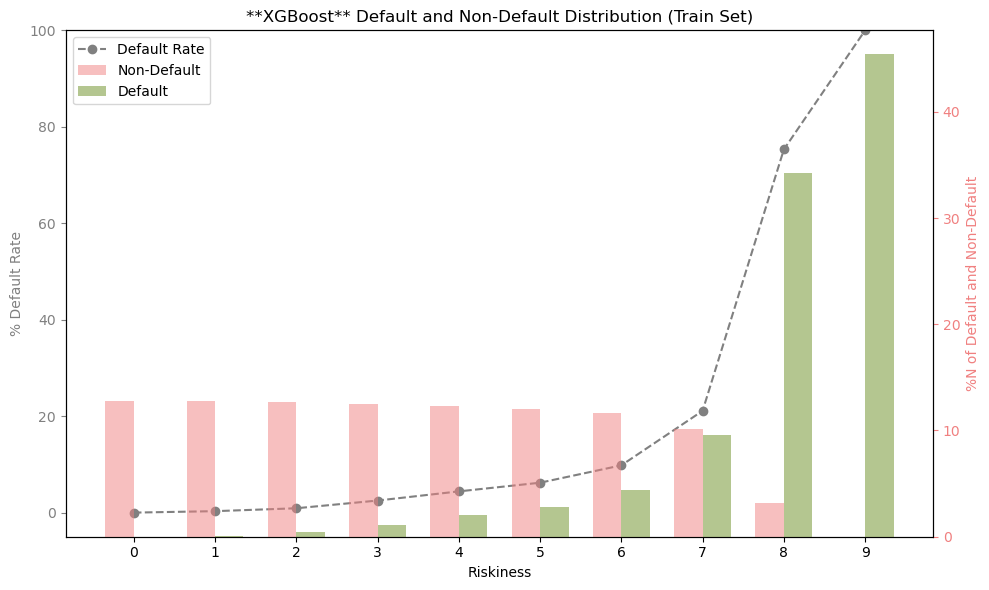

bin  count   pos   neg  % pos  % dist pos  % dist neg
0    0   2078     0  2078    0.0         0.0        12.8
1    1   2071     6  2065    0.3         0.1        12.8
2    2   2076    18  2058    0.9         0.4        12.7
3    3   2073    52  2021    2.5         1.1        12.5
4    4   2075    91  1984    4.4         2.0        12.3
5    5   2074   128  1946    6.2         2.8        12.0
6    6   2074   203  1871    9.8         4.4        11.6
7    7   2075   437  1638   21.1         9.6        10.1
8    8   2074  1561   513   75.3        34.2         3.2
9    9   2075  2075     0  100.0        45.4         0.0

In [267]:
model_performance_plot(df=train, prob_name='xgb_raw_prob', model_name='XGBoost', set='Train')

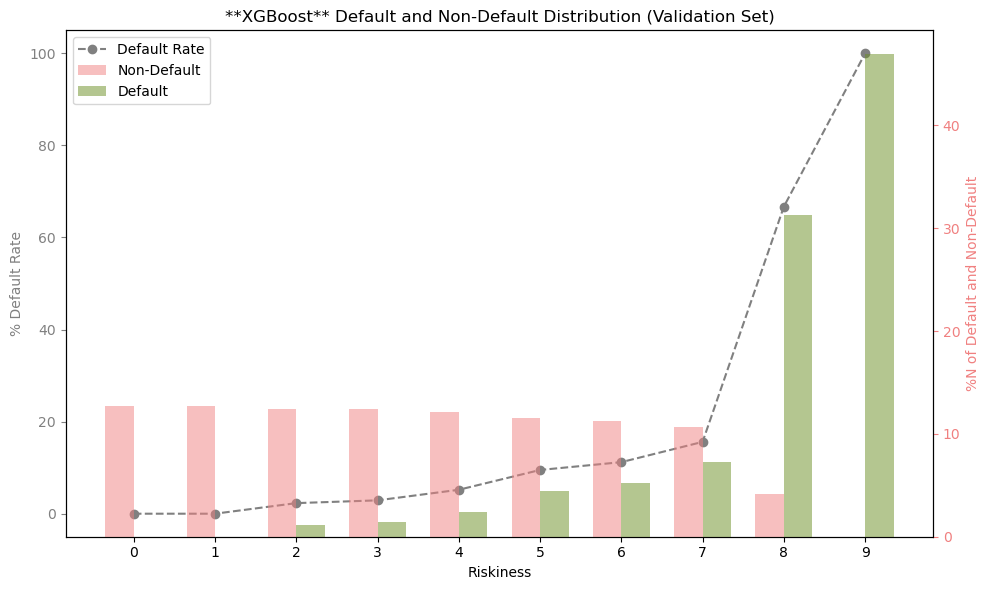

bin  count  pos  neg  % pos  % dist pos  % dist neg
0    0    519    0  519    0.0         0.0        12.7
1    1    519    0  519    0.0         0.0        12.7
2    2    518   12  506    2.3         1.1        12.4
3    3    519   15  504    2.9         1.4        12.4
4    4    519   27  492    5.2         2.4        12.1
5    5    518   49  469    9.5         4.4        11.5
6    6    519   58  461   11.2         5.2        11.3
7    7    518   81  437   15.6         7.3        10.7
8    8    519  346  173   66.7        31.3         4.2
9    9    519  519    0  100.0        46.9         0.0

In [262]:
model_performance_plot(df=valid, prob_name='xgb_raw_prob', model_name='XGBoost', set='Validation')

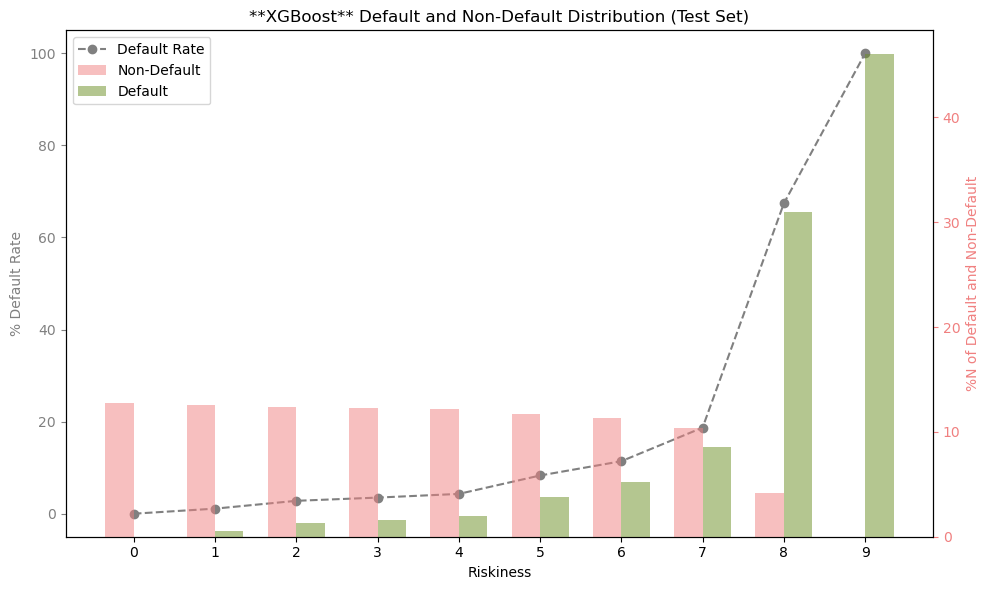

bin  count  pos  neg  % pos  % dist pos  % dist neg
0    0    649    0  649    0.0         0.0        12.8
1    1    648    7  641    1.1         0.5        12.6
2    2    649   18  631    2.8         1.3        12.4
3    3    648   23  625    3.5         1.6        12.3
4    4    648   28  620    4.3         2.0        12.2
5    5    648   54  594    8.3         3.8        11.7
6    6    649   74  575   11.4         5.2        11.3
7    7    648  121  527   18.7         8.6        10.4
8    8    648  437  211   67.4        31.0         4.2
9    9    649  649    0  100.0        46.0         0.0

In [263]:
model_performance_plot(df=test, prob_name='xgb_raw_prob', model_name='XGBoost', set='Test')

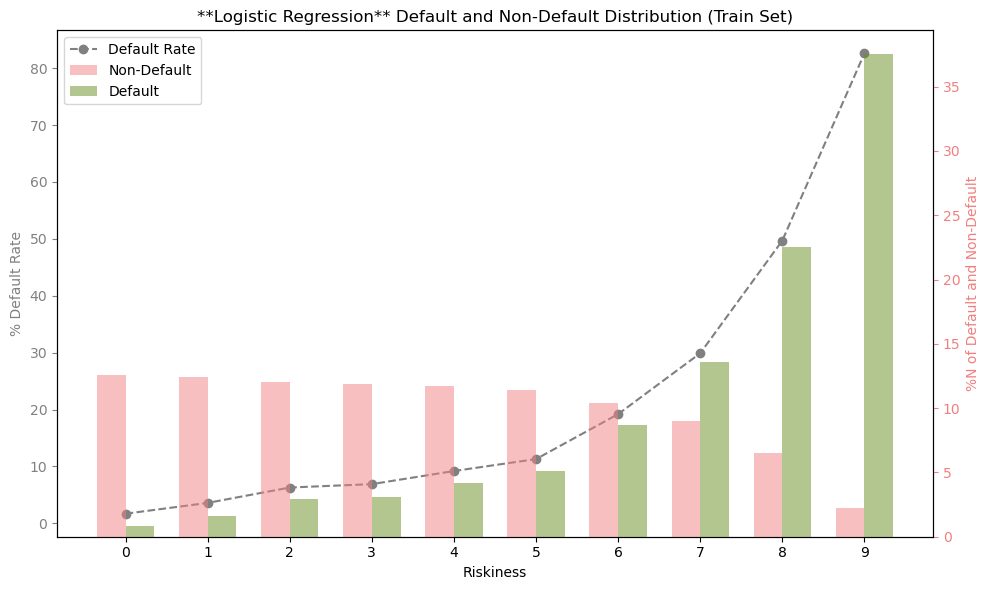

bin  count   pos   neg  % pos  % dist pos  % dist neg
0    0   2075    36  2039    1.7         0.8        12.6
1    1   2074    74  2000    3.6         1.6        12.4
2    2   2075   131  1944    6.3         2.9        12.0
3    3   2074   143  1931    6.9         3.1        11.9
4    4   2075   190  1885    9.2         4.2        11.7
5    5   2074   234  1840   11.3         5.1        11.4
6    6   2074   399  1675   19.2         8.7        10.4
7    7   2075   621  1454   29.9        13.6         9.0
8    8   2074  1030  1044   49.7        22.5         6.5
9    9   2075  1713   362   82.6        37.5         2.2

In [264]:
model_performance_plot(df=train, prob_name='lr_raw_prob', model_name='Logistic Regression', set='Train')

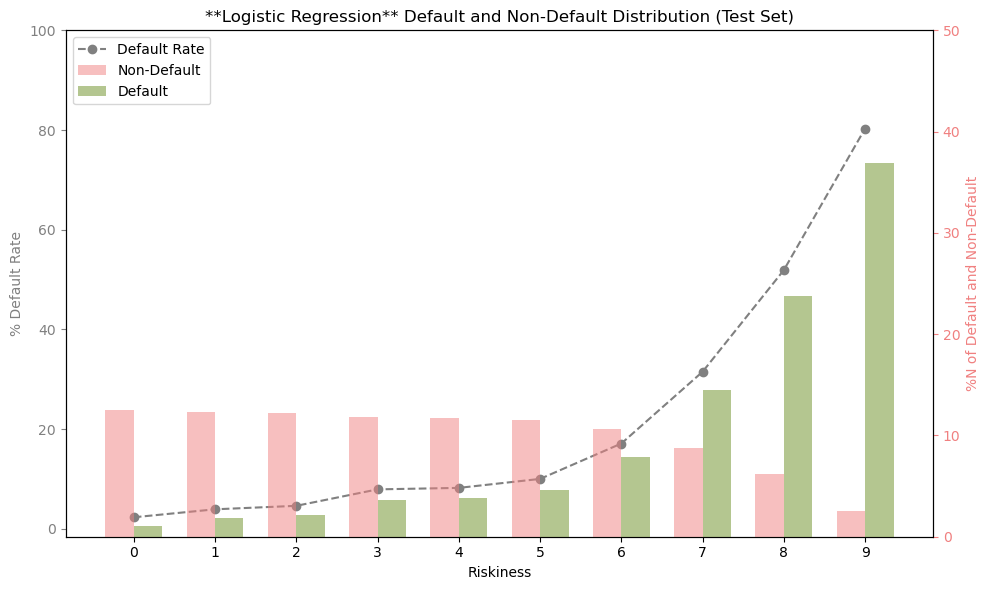

bin  count  pos  neg  % pos  % dist pos  % dist neg
0    0    649   15  634    2.3         1.1        12.5
1    1    648   25  623    3.9         1.8        12.3
2    2    648   30  618    4.6         2.1        12.2
3    3    649   51  598    7.9         3.6        11.8
4    4    648   53  595    8.2         3.8        11.7
5    5    648   65  583   10.0         4.6        11.5
6    6    649  111  538   17.1         7.9        10.6
7    7    648  204  444   31.5        14.5         8.8
8    8    648  336  312   51.9        23.8         6.2
9    9    649  521  128   80.3        36.9         2.5

In [270]:
model_performance_plot(df=test, prob_name='lr_raw_prob', model_name='Logistic Regression', set='Test')

### *kolmogorov_smirnov_test and CDFs*

KS Statistic (Logistic Regression): 0.5629, p-value: 0


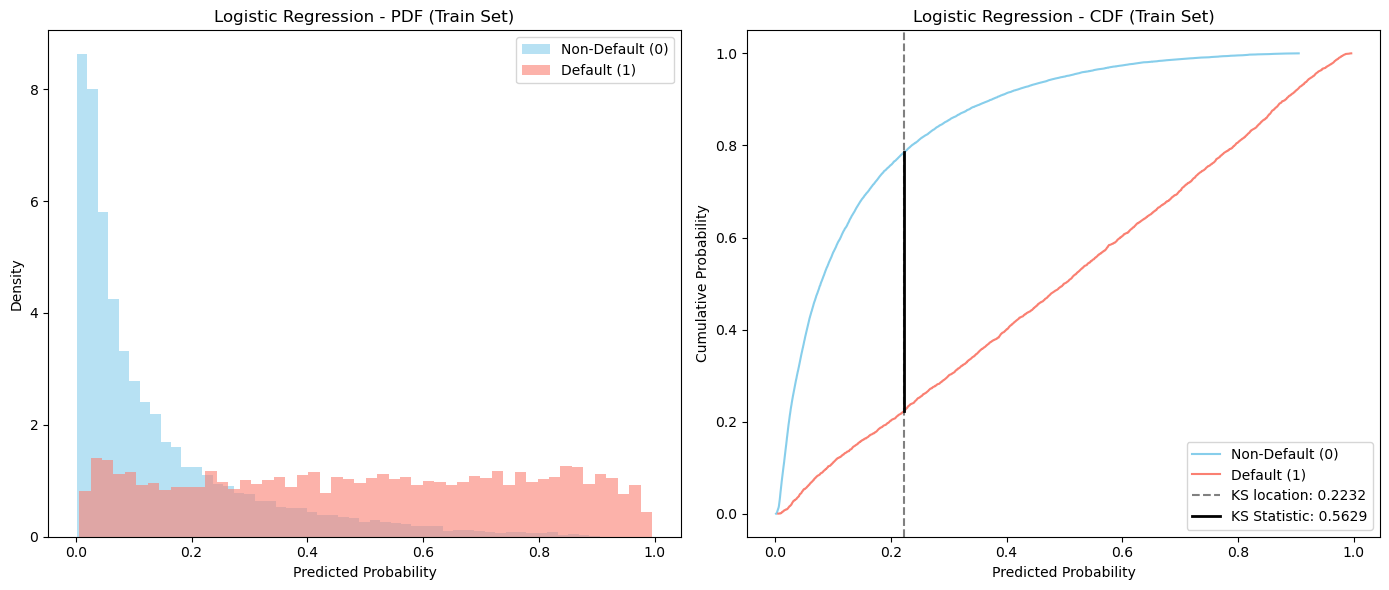

KS Statistic (Logistic Regression): 0.5832, p-value: 4.703e-277


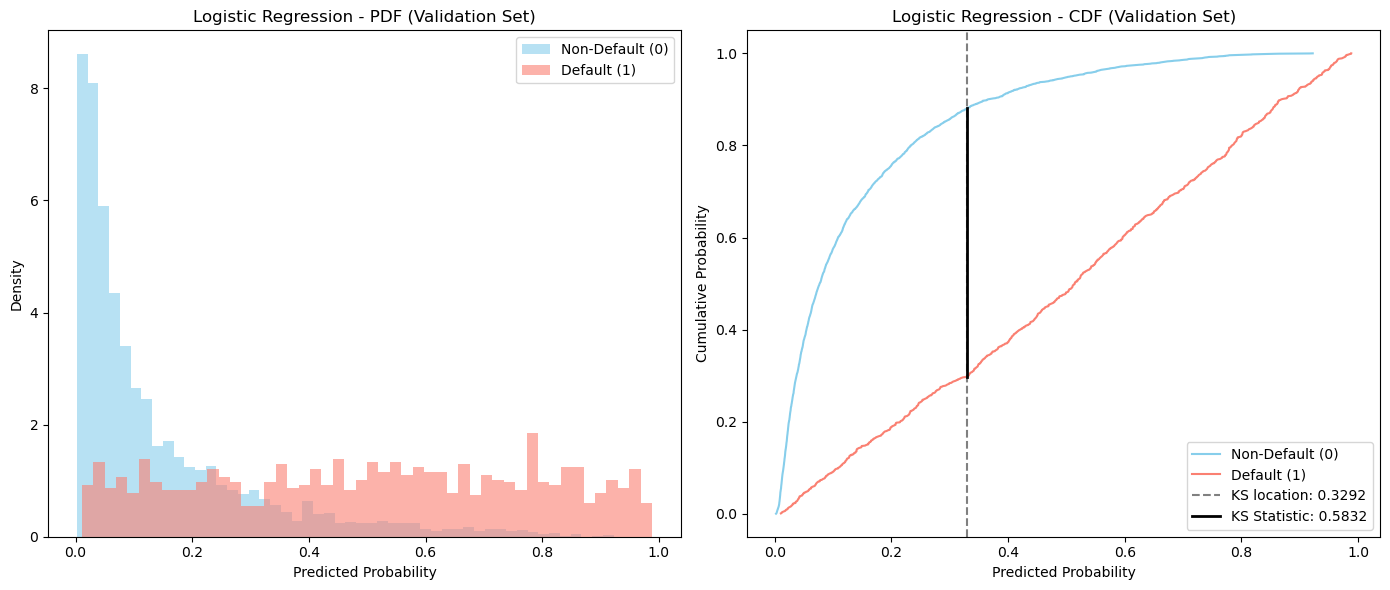

KS Statistic (Logistic Regression): 0.5831, p-value: 3.34e-321


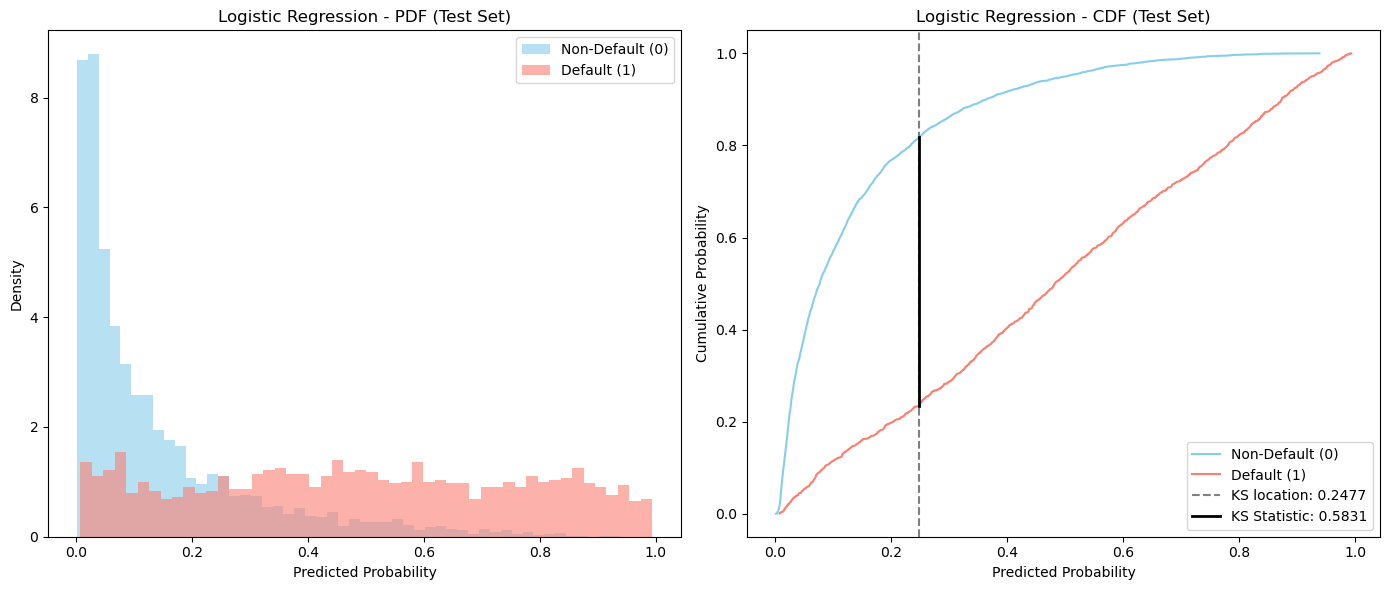

(0.5830767324350101, 3.34e-321)

In [31]:
# Logistic Regression on train set
plot_ks_and_cdf(train, 'lr_raw_prob', label='(Train Set)', model_name='Logistic Regression')

# Logistic Regression on validation set
plot_ks_and_cdf(valid, 'lr_raw_prob', label='(Validation Set)', model_name='Logistic Regression')

# Logistic Regression on test set
plot_ks_and_cdf(test, 'lr_raw_prob', label='(Test Set)', model_name='Logistic Regression')

KS Statistic (XGBoost): 0.7732, p-value: 0


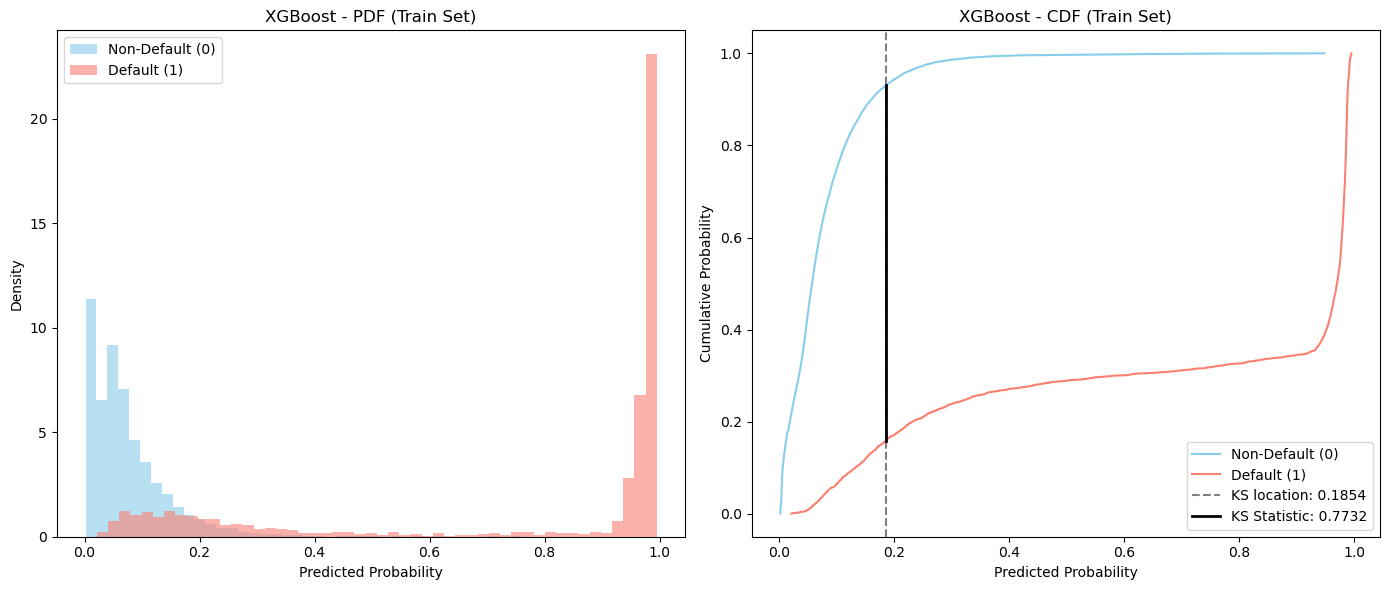

KS Statistic (XGBoost): 0.7419, p-value: 1.191e-321


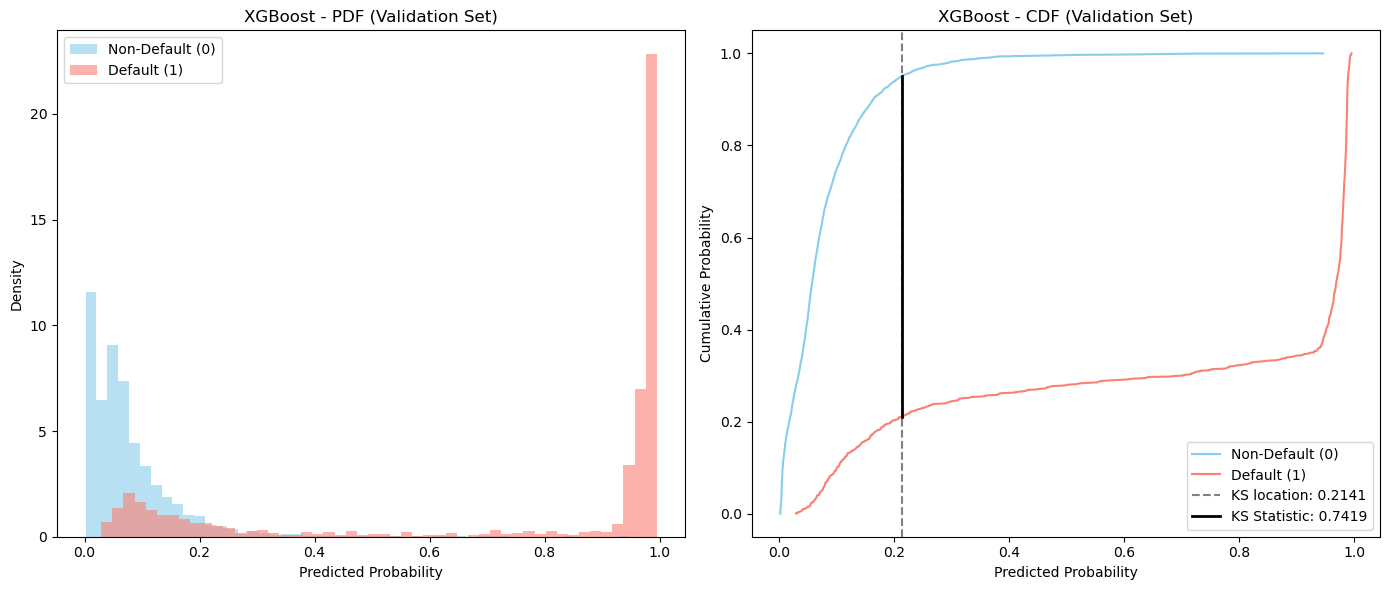

KS Statistic (XGBoost): 0.7333, p-value: 1.369e-321


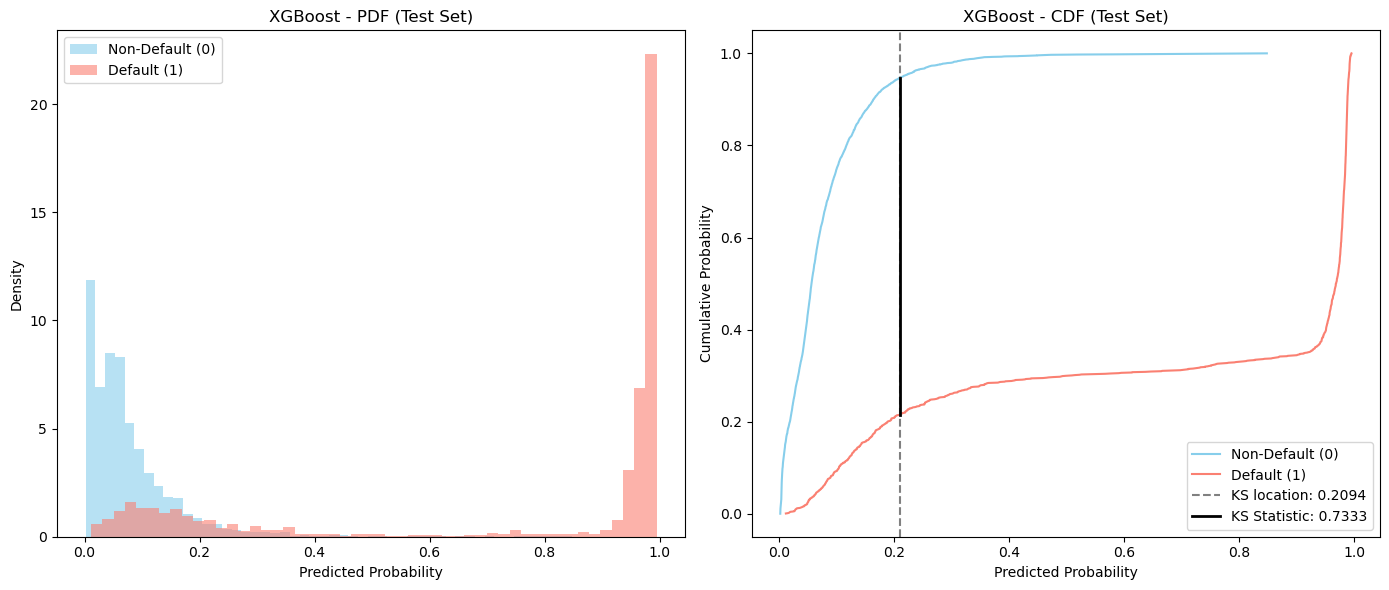

(0.7333358200604275, 1.37e-321)

In [32]:
# XGBoost on train set
plot_ks_and_cdf(train, 'xgb_raw_prob', label='(Train Set)', model_name='XGBoost')

# XGBoost on validation set
plot_ks_and_cdf(valid, 'xgb_raw_prob', label='(Validation Set)', model_name='XGBoost')

# XGBoost on test set
plot_ks_and_cdf(test, 'xgb_raw_prob', label='(Test Set)', model_name='XGBoost')

## `Calibration`

### *Performance*

In [33]:
calibration_perf_train = get_calibration_performance(train, split_strategy='quantile')
calibration_perf_valid = get_calibration_performance(valid, split_strategy='quantile', additional_prob='boot_mean_prob')
calibration_perf_test = get_calibration_performance(test, split_strategy='quantile', additional_prob='boot_mean_prob')

In [34]:
calibration_perf_train.sort_values(by=['ECE', 'Log Loss', 'Brier Score'], ascending=True)

Method  Log Loss  Brier Score    ECE
4    lr_venn_cvap     0.357        0.110  0.004
3    lr_venn_ivap     0.359        0.110  0.013
2     lr_iso_prob     0.367        0.110  0.014
1   lr_platt_prob     0.360        0.110  0.015
9   xgb_venn_cvap     0.187        0.053  0.017
0     lr_raw_prob     0.359        0.110  0.017
7    xgb_iso_prob     0.194        0.052  0.019
8   xgb_venn_ivap     0.182        0.052  0.021
6  xgb_platt_prob     0.189        0.052  0.026
5    xgb_raw_prob     0.187        0.052  0.027

In [35]:
calibration_perf_valid.sort_values(by=['ECE', 'Log Loss', 'Brier Score'], ascending=True)

Method  Log Loss  Brier Score    ECE
7     xgb_iso_prob     0.183        0.052  0.000
2      lr_iso_prob     0.337        0.104  0.000
8    xgb_venn_ivap     0.186        0.052  0.004
3     lr_venn_ivap     0.339        0.104  0.005
10  boot_mean_prob     0.341        0.105  0.009
4     lr_venn_cvap     0.343        0.105  0.012
5     xgb_raw_prob     0.194        0.053  0.015
1    lr_platt_prob     0.344        0.105  0.016
0      lr_raw_prob     0.345        0.106  0.017
9    xgb_venn_cvap     0.172        0.048  0.019
6   xgb_platt_prob     0.198        0.053  0.023

In [36]:
calibration_perf_test.sort_values(by=['ECE', 'Log Loss', 'Brier Score'], ascending=True)

Method  Log Loss  Brier Score    ECE
9    xgb_venn_cvap     0.199        0.056  0.008
8    xgb_venn_ivap     0.201        0.056  0.010
7     xgb_iso_prob     0.267        0.056  0.010
5     xgb_raw_prob     0.203        0.056  0.013
4     lr_venn_cvap     0.354        0.108  0.013
10  boot_mean_prob     0.359        0.108  0.013
2      lr_iso_prob     0.385        0.109  0.015
3     lr_venn_ivap     0.356        0.109  0.016
6   xgb_platt_prob     0.207        0.057  0.018
1    lr_platt_prob     0.357        0.109  0.020
0      lr_raw_prob     0.357        0.109  0.022

### *Calibration Curves*

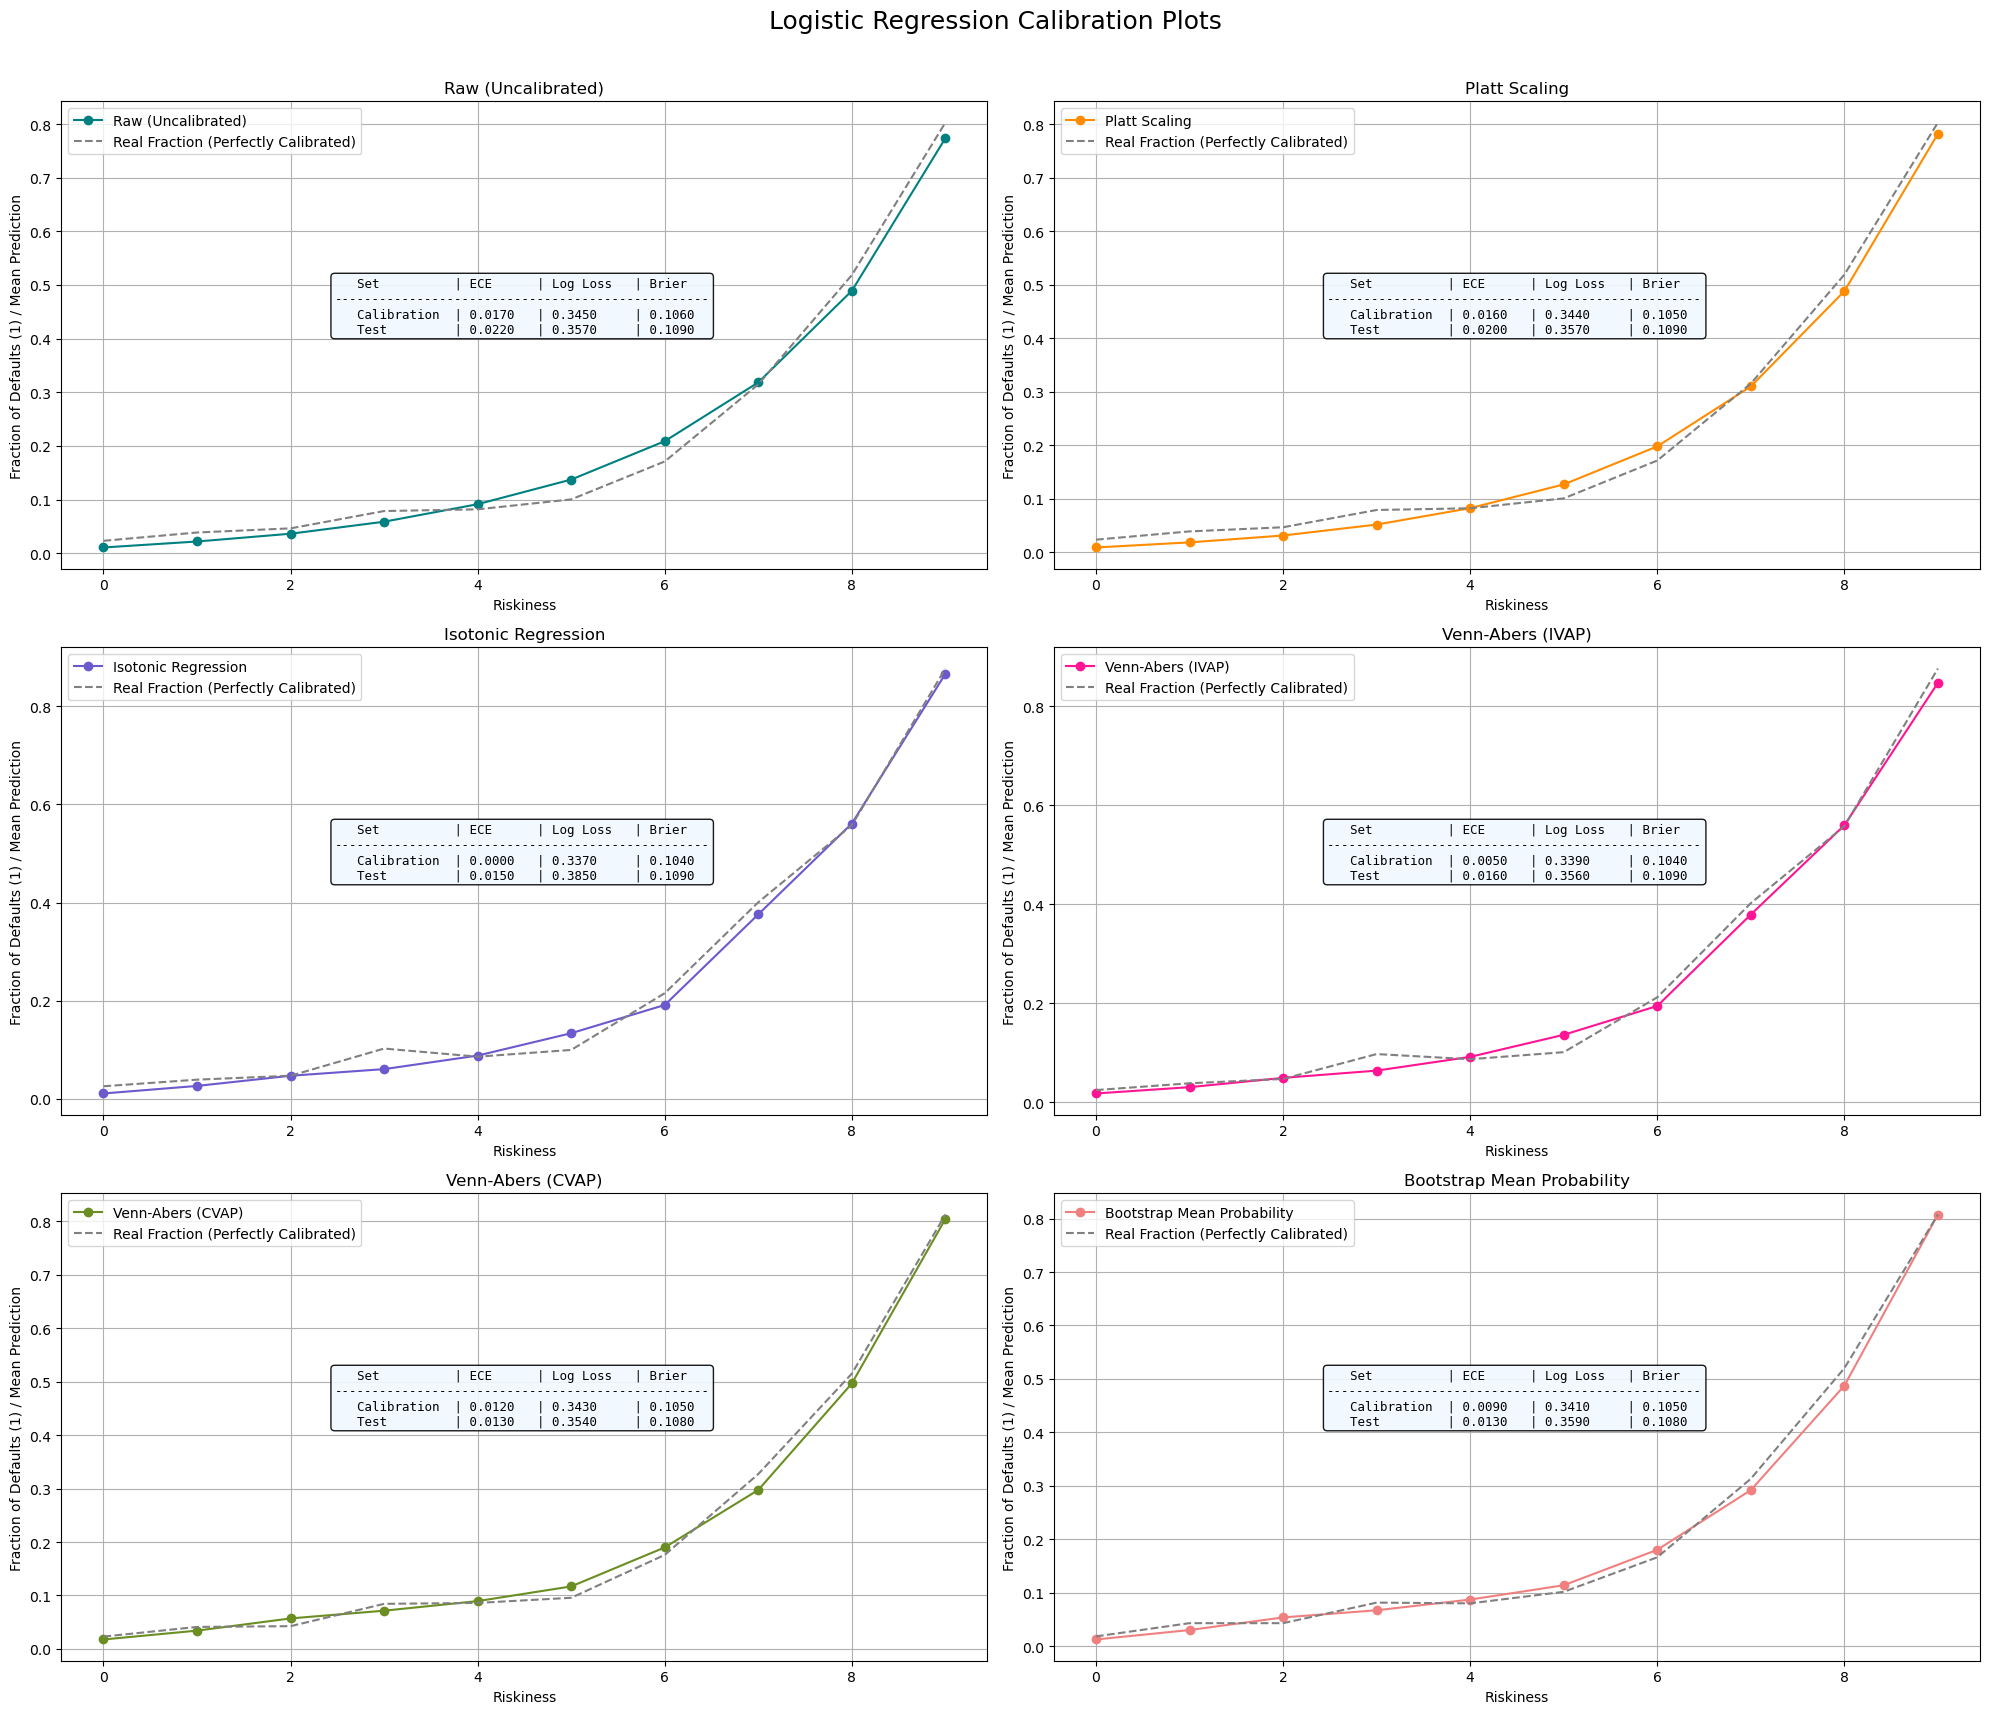

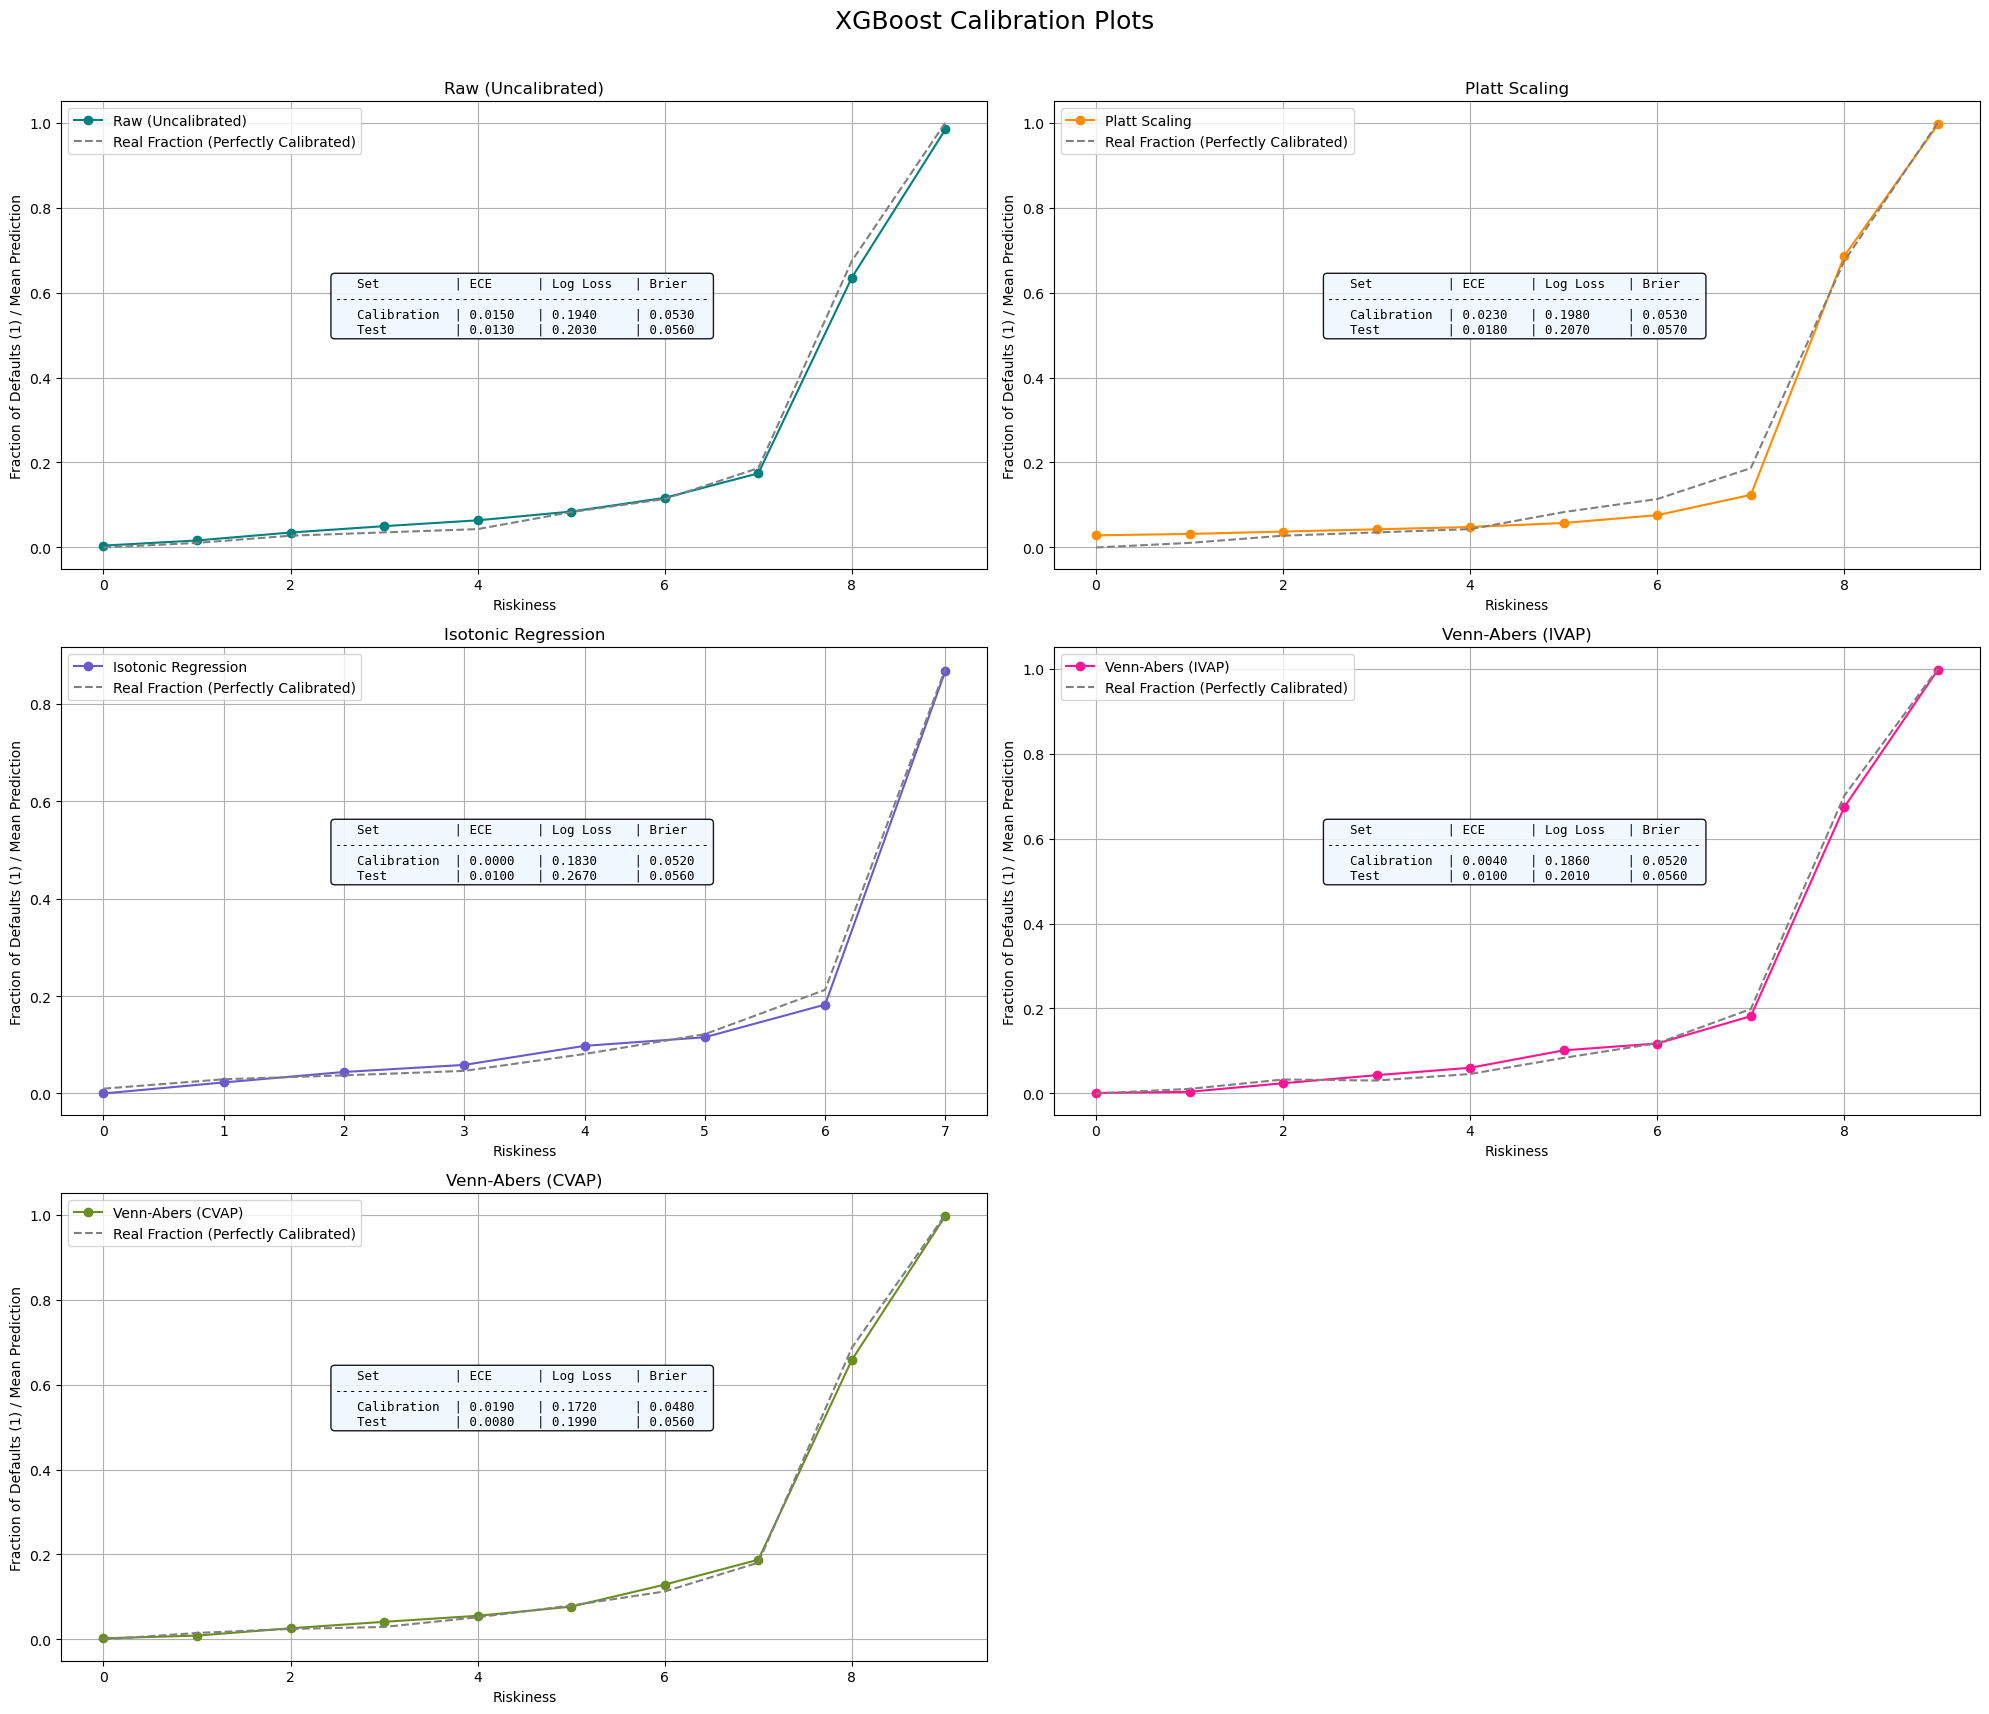

In [274]:
# Assuming 'test', 'calibration_perf_test', and 'calibration_perf_valid' DataFrames are available

# --- 1. Prepare both metrics DataFrames by setting the index ---
# calibration_perf_test.set_index('Method', inplace=True)
# calibration_perf_valid.set_index('Method', inplace=True)

# --- Define model suffixes and their properties for plotting ---
model_map = {
    'raw_prob': 'Raw (Uncalibrated)',
    'platt_prob': 'Platt Scaling',
    'iso_prob': 'Isotonic Regression',
    'venn_ivap': 'Venn-Abers (IVAP)',
    'venn_cvap': 'Venn-Abers (CVAP)',
    'boot_mean_prob': 'Bootstrap Mean Probability'
}
colors = {
    'raw_prob': 'teal',
    'platt_prob': 'darkorange',
    'iso_prob': 'slateblue',
    'venn_ivap': 'deeppink',
    'venn_cvap': 'olivedrab',
    'boot_mean_prob': 'lightcoral'
}

# --- Outer loop to create a separate figure for each base model ---
for node in ['lr', 'xgb']:
    
    fig, axs = plt.subplots(3, 2, figsize=(20, 18))
    axs = axs.flatten()
    fig.suptitle(f'{"Logistic Regression" if node=="lr" else "XGBoost"} Calibration Plots', fontsize=18)

    # --- Inner loop to create a plot for each model type ---
    for i, model_suffix in enumerate(model_map.keys()):
        ax = axs[i]
        col_name = f'{node}_{model_suffix}' if (model_suffix != 'boot_mean_prob') or (node != 'lr') else 'boot_mean_prob'
        model_name = model_map[model_suffix]

        if col_name in test.columns:
            # Plotting logic remains the same
            fraction_of_positives, mean_predicted_value = calibration_curve(
                test['loan_status'], test[col_name], n_bins=10, strategy='quantile'
            )
            
            ax.plot(range(len(mean_predicted_value)), mean_predicted_value, marker='o', label=model_name, color=colors[model_suffix])
            ax.plot(range(len(fraction_of_positives)), fraction_of_positives, '--', label='Real Fraction (Perfectly Calibrated)', color='grey')
            ax.set_title(model_name)
            ax.set_xlabel('Riskiness')
            ax.set_ylabel('Fraction of Defaults (1) / Mean Prediction')
            ax.legend(loc='upper left')
            ax.grid(True)

            # --- MODIFIED SECTION: Add metrics table for both sets ---
            metric_key = f'{node}_{model_suffix}' if (model_suffix != 'boot_mean_prob') or (node != 'lr') else 'boot_mean_prob'
            
            # Initialize metrics_text with a header
            metrics_text = f'{"Set":<12} | {"ECE":<8} | {"Log Loss":<10} | {"Brier":<8}\n'
            metrics_text += "-" * 50 + "\n"
            
            # Get and format VALIDATION metrics
            if metric_key in calibration_perf_valid.index:
                valid_metrics = calibration_perf_valid.loc[metric_key]
                metrics_text += (f'{"Calibration":<12} | {valid_metrics["ECE"]:<8.4f} | '
                                 f'{valid_metrics["Log Loss"]:<10.4f} | {valid_metrics["Brier Score"]:<8.4f}\n')

            # Get and format TEST metrics
            if metric_key in calibration_perf_test.index:
                test_metrics = calibration_perf_test.loc[metric_key]
                metrics_text += (f'{"Test":<12} | {test_metrics["ECE"]:<8.4f} | '
                                 f'{test_metrics["Log Loss"]:<10.4f} | {test_metrics["Brier Score"]:<8.4f}')
            
            bbox_props = dict(boxstyle='round,pad=0.3', fc='aliceblue', alpha=0.9)
            
            # Add the text box to the subplot
            ax.text(0.7, 0.5, metrics_text, transform=ax.transAxes, fontsize=9,
                    verticalalignment='bottom', horizontalalignment='right', bbox=bbox_props, fontname='monospace')
            # --- End of Modified Section ---

        else:
        #     ax.text(0.5, 0.5, f'Column "{col_name}"\nnot found', 
        #             ha='center', va='center', fontsize=12, color='red')
            ax.axis('off')

    # Hide any unused subplots
    if len(model_map) < len(axs):
        for j in range(len(model_map), len(axs)):
            fig.delaxes(axs[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

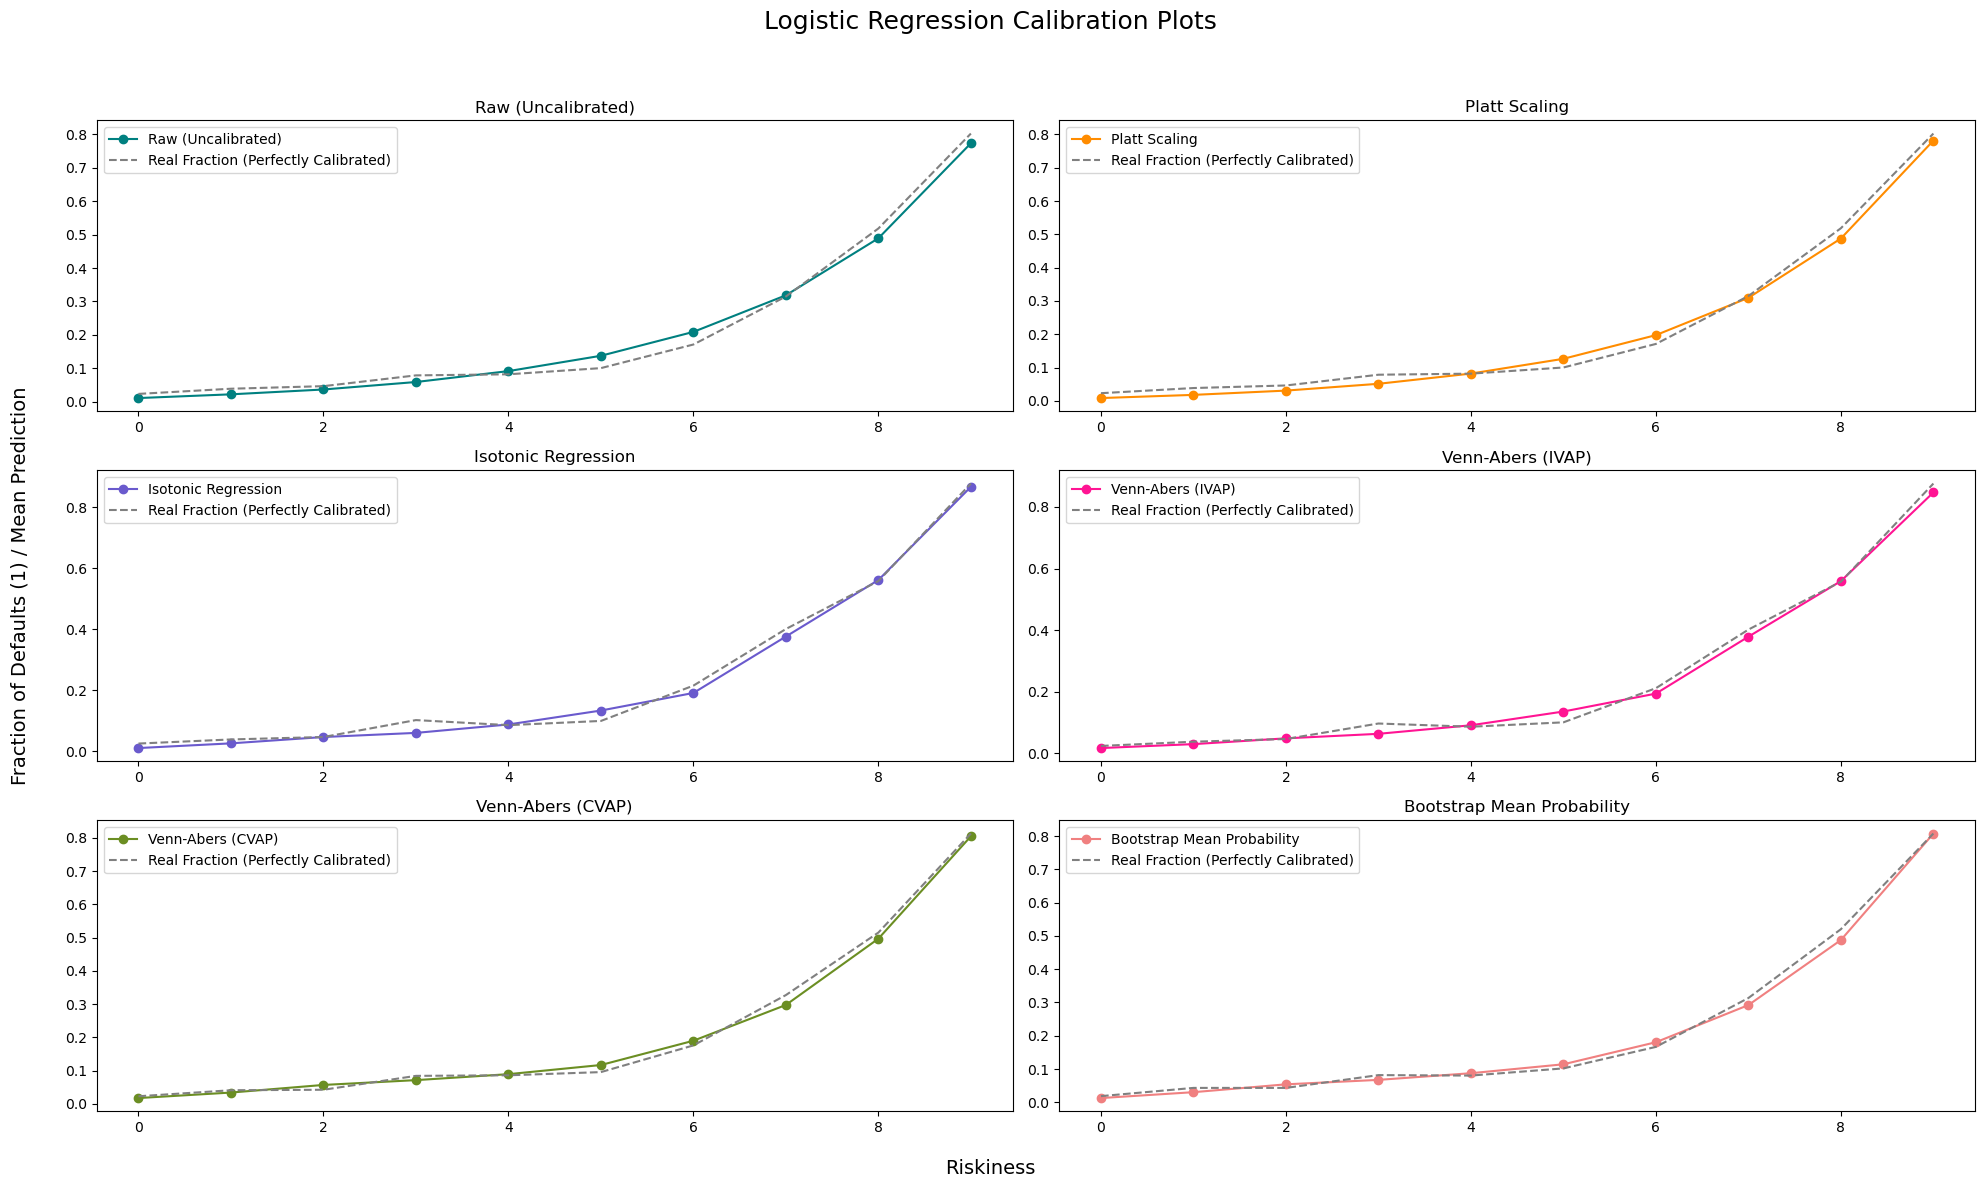

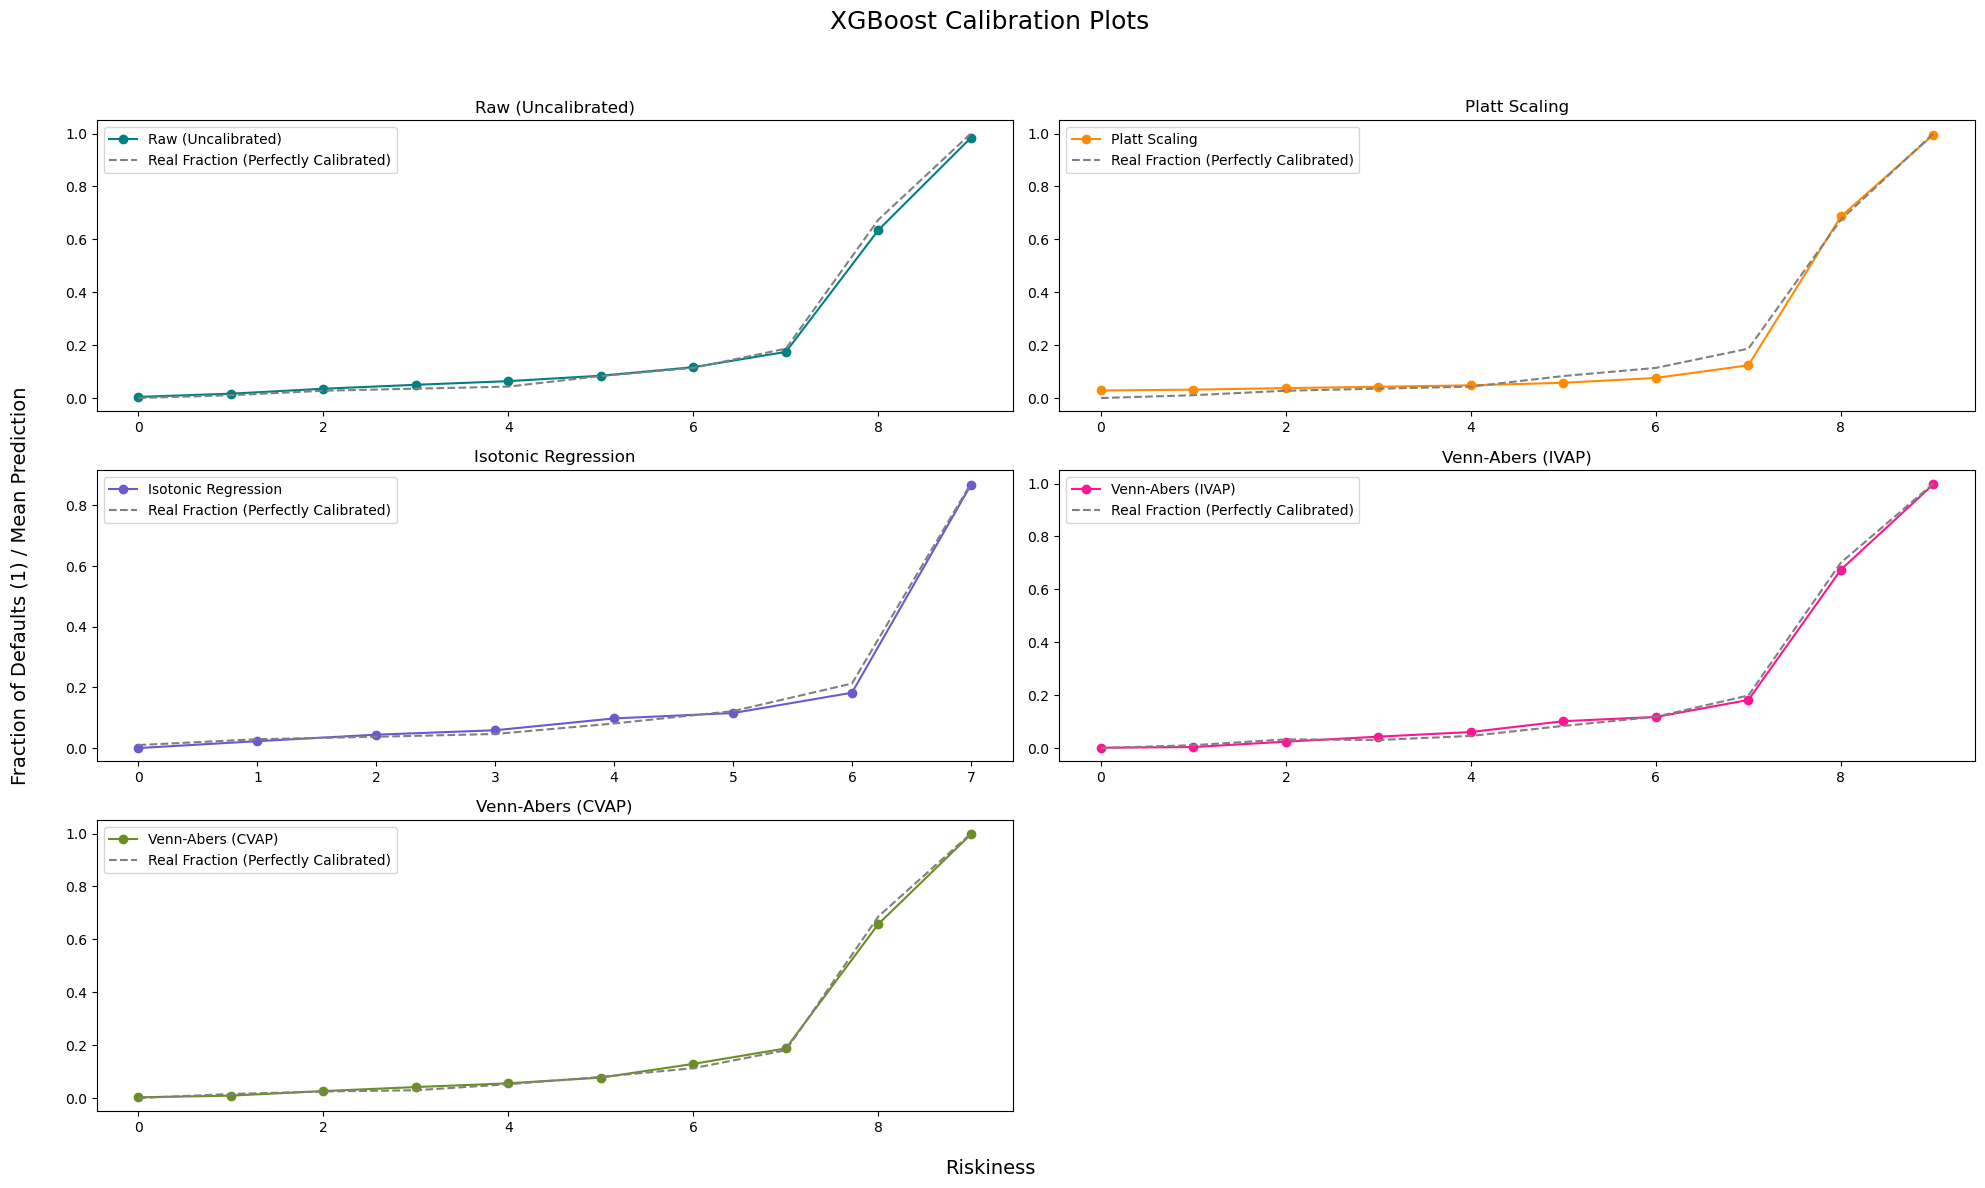

In [282]:
# Assuming 'test', 'calibration_perf_test', and 'calibration_perf_valid' DataFrames are available

# --- 1. Prepare both metrics DataFrames by setting the index ---
# calibration_perf_test.set_index('Method', inplace=True)
# calibration_perf_valid.set_index('Method', inplace=True)

# --- Define model suffixes and their properties for plotting ---
model_map = {
    'raw_prob': 'Raw (Uncalibrated)',
    'platt_prob': 'Platt Scaling',
    'iso_prob': 'Isotonic Regression',
    'venn_ivap': 'Venn-Abers (IVAP)',
    'venn_cvap': 'Venn-Abers (CVAP)',
    'boot_mean_prob': 'Bootstrap Mean Probability'
}
colors = {
    'raw_prob': 'teal',
    'platt_prob': 'darkorange',
    'iso_prob': 'slateblue',
    'venn_ivap': 'deeppink',
    'venn_cvap': 'olivedrab',
    'boot_mean_prob': 'lightcoral'
}

# # --- Outer loop to create a separate figure for each base model ---
# for node in ['lr', 'xgb']:
    
#     fig, axs = plt.subplots(3, 2, figsize=(20, 10))
#     axs = axs.flatten()
#     fig.suptitle(f'{"Logistic Regression" if node=="lr" else "XGBoost"} Calibration Plots', fontsize=18)

#     # --- Inner loop to create a plot for each model type ---
#     for i, model_suffix in enumerate(model_map.keys()):
#         ax = axs[i]
#         col_name = f'{node}_{model_suffix}' if (model_suffix != 'boot_mean_prob') or (node != 'lr') else 'boot_mean_prob'
#         model_name = model_map[model_suffix]

#         if col_name in test.columns:
#             # Plotting logic remains the same
#             fraction_of_positives, mean_predicted_value = calibration_curve(
#                 test['loan_status'], test[col_name], n_bins=10, strategy='quantile'
#             )
            
#             ax.plot(range(len(mean_predicted_value)), mean_predicted_value, marker='o', label=model_name, color=colors[model_suffix])
#             ax.plot(range(len(fraction_of_positives)), fraction_of_positives, '--', label='Real Fraction (Perfectly Calibrated)', color='grey')
#             ax.set_title(model_name)
#             ax.set_xlabel('Riskiness')
#             ax.set_ylabel('Fraction of Defaults (1) / Mean Prediction')
#             ax.legend(loc='upper left')
#             ax.grid(True)

#         else:
#         #     ax.text(0.5, 0.5, f'Column "{col_name}"\nnot found', 
#         #             ha='center', va='center', fontsize=12, color='red')
#             ax.axis('off')

#     # Hide any unused subplots
#     if len(model_map) < len(axs):
#         for j in range(len(model_map), len(axs)):
#             fig.delaxes(axs[j])

#     plt.tight_layout(rect=[0, 0.03, 1, 0.97])
#     plt.show()

# --- Outer loop to create a separate figure for each base model ---
for node in ['lr', 'xgb']:
    
    fig, axs = plt.subplots(3, 2, figsize=(20, 12))
    axs = axs.flatten()
    fig.suptitle(f'{"Logistic Regression" if node=="lr" else "XGBoost"} Calibration Plots', fontsize=18)

    # --- Inner loop to create a plot for each model type ---
    for i, model_suffix in enumerate(model_map.keys()):
        ax = axs[i]
        col_name = f'{node}_{model_suffix}' if (model_suffix != 'boot_mean_prob') or (node != 'lr') else 'boot_mean_prob'
        model_name = model_map[model_suffix]

        if col_name in test.columns:
            fraction_of_positives, mean_predicted_value = calibration_curve(
                test['loan_status'], test[col_name], n_bins=10, strategy='quantile'
            )
            
            ax.plot(range(len(mean_predicted_value)), mean_predicted_value, marker='o', 
                    label=model_name, color=colors[model_suffix])
            ax.plot(range(len(fraction_of_positives)), fraction_of_positives, '--', 
                    label='Real Fraction (Perfectly Calibrated)', color='grey')
            ax.set_title(model_name)
            ax.legend(loc='upper left')
            # ax.grid(True)
            ax.grid(False)

        else:
            ax.axis('off')

    # Hide any unused subplots
    if len(model_map) < len(axs):
        for j in range(len(model_map), len(axs)):
            fig.delaxes(axs[j])

    # --- Global labels ---
    fig.text(0.5, 0.01, 'Riskiness', ha='center', fontsize=14)   # Global X label
    fig.text(0.01, 0.5, 'Fraction of Defaults (1) / Mean Prediction', 
             va='center', rotation='vertical', fontsize=14)       # Global Y label

    plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])  # leave space for labels and title
    plt.show()


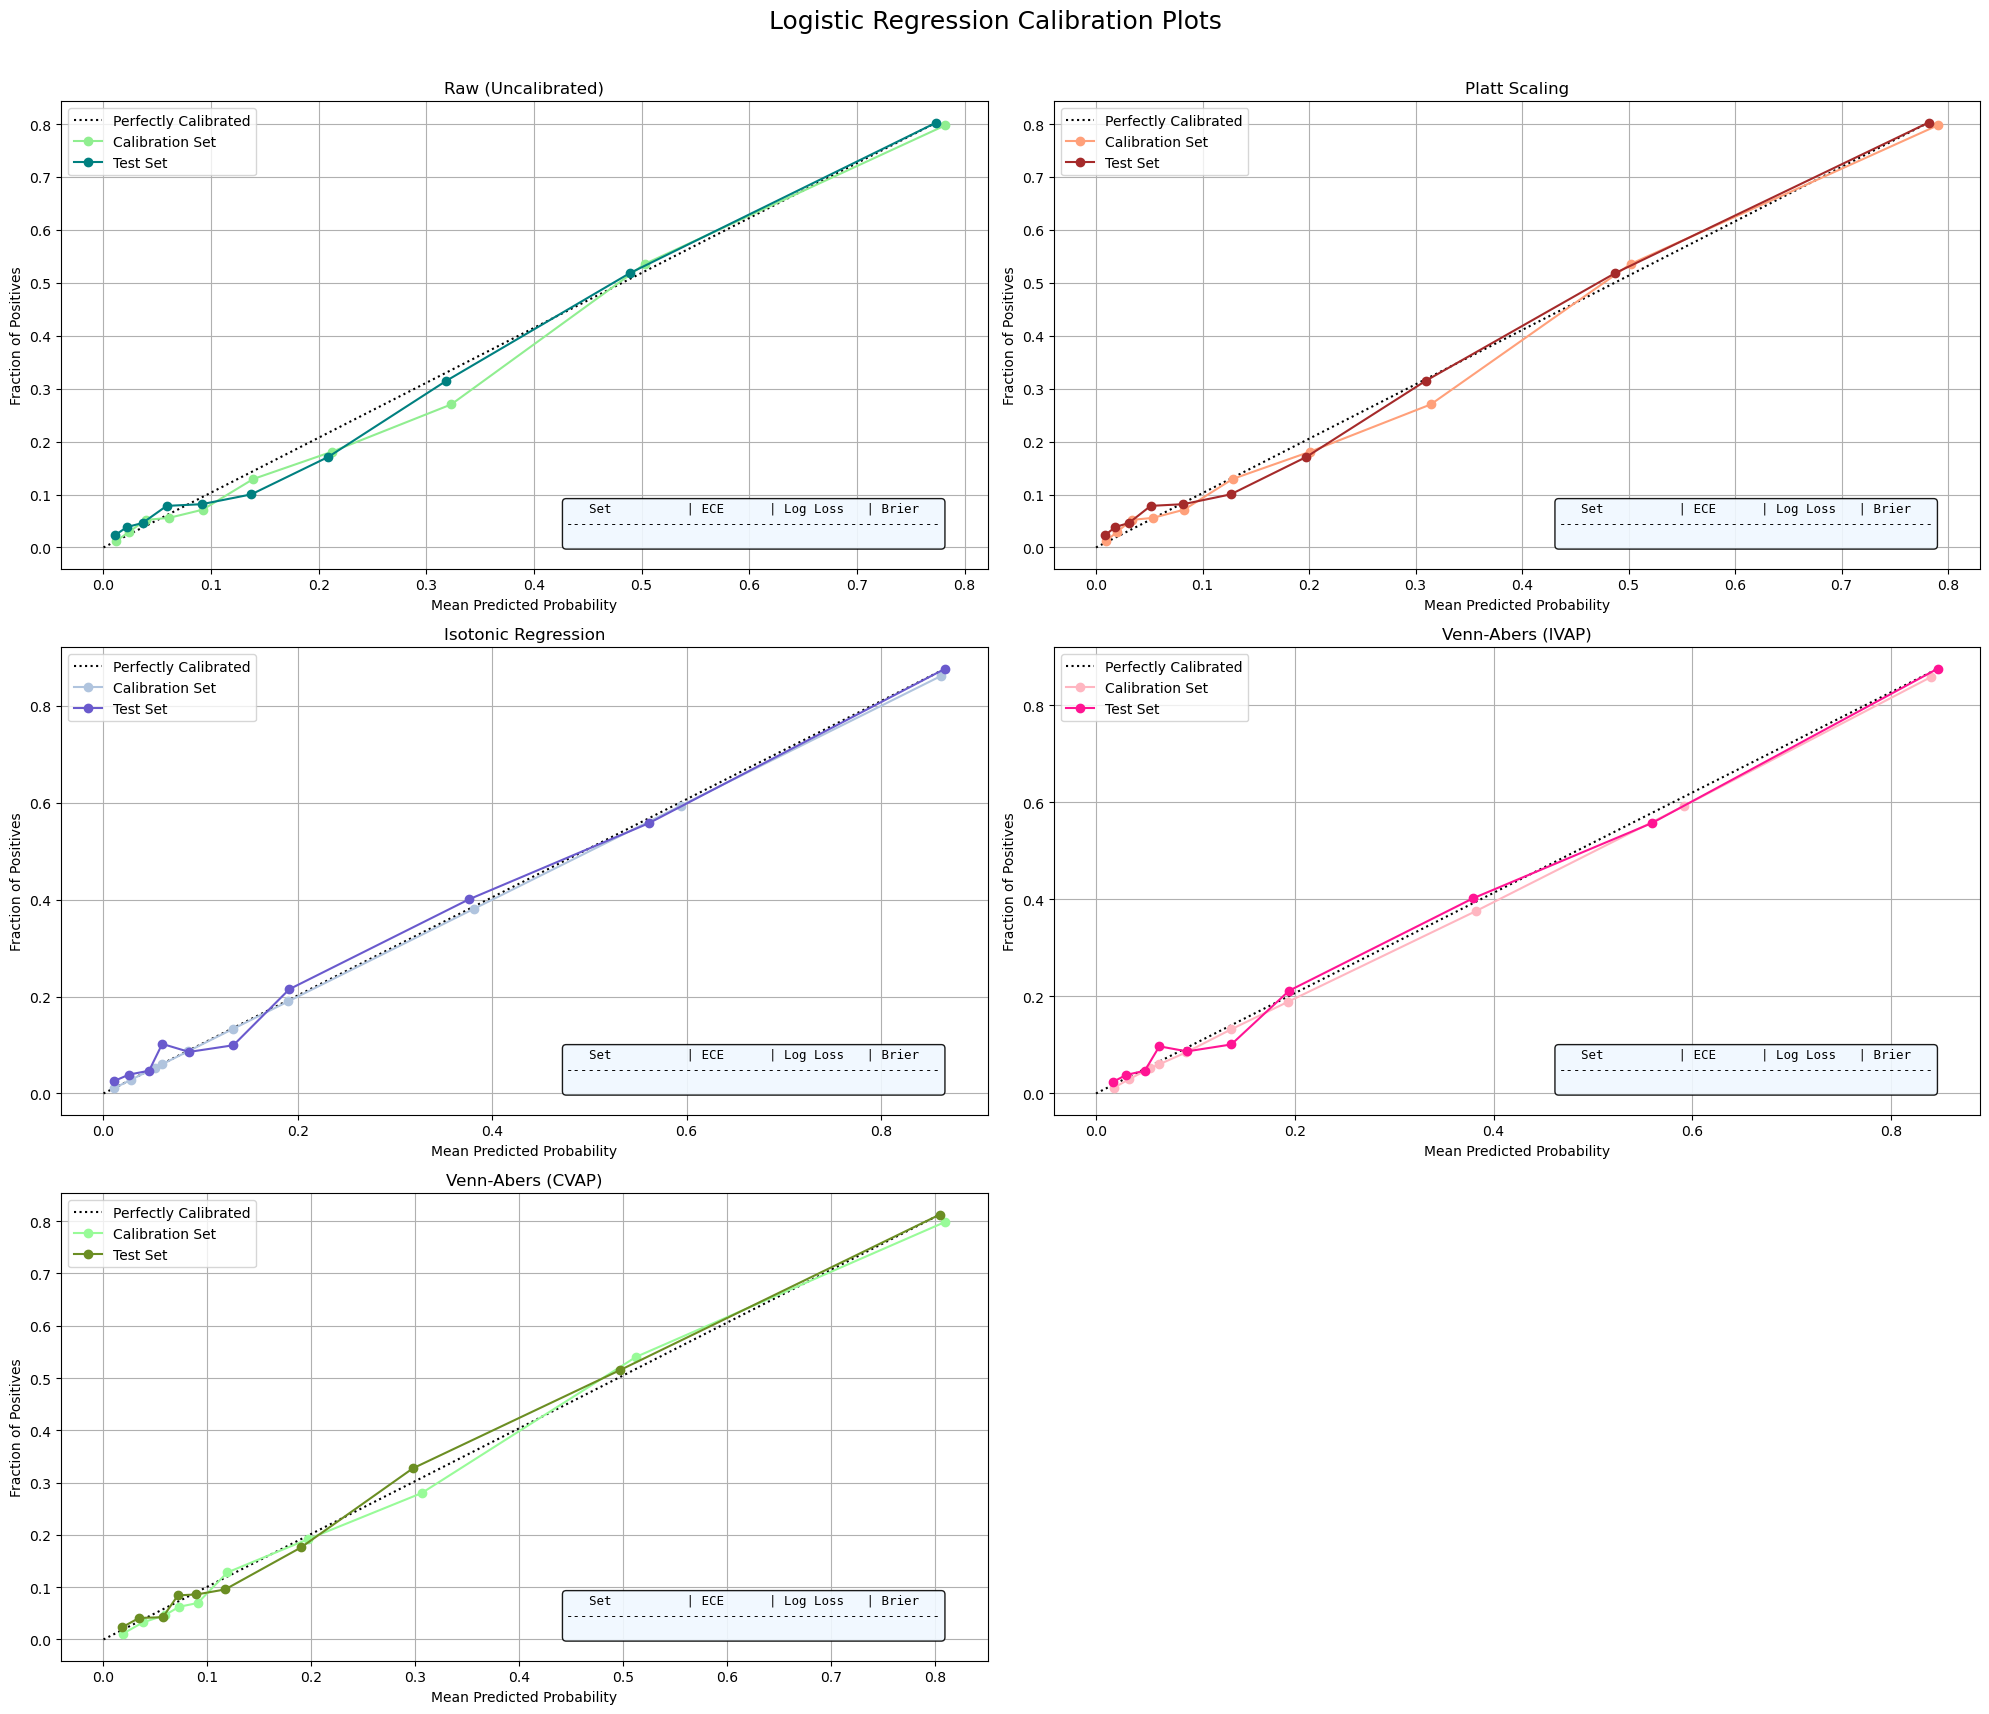

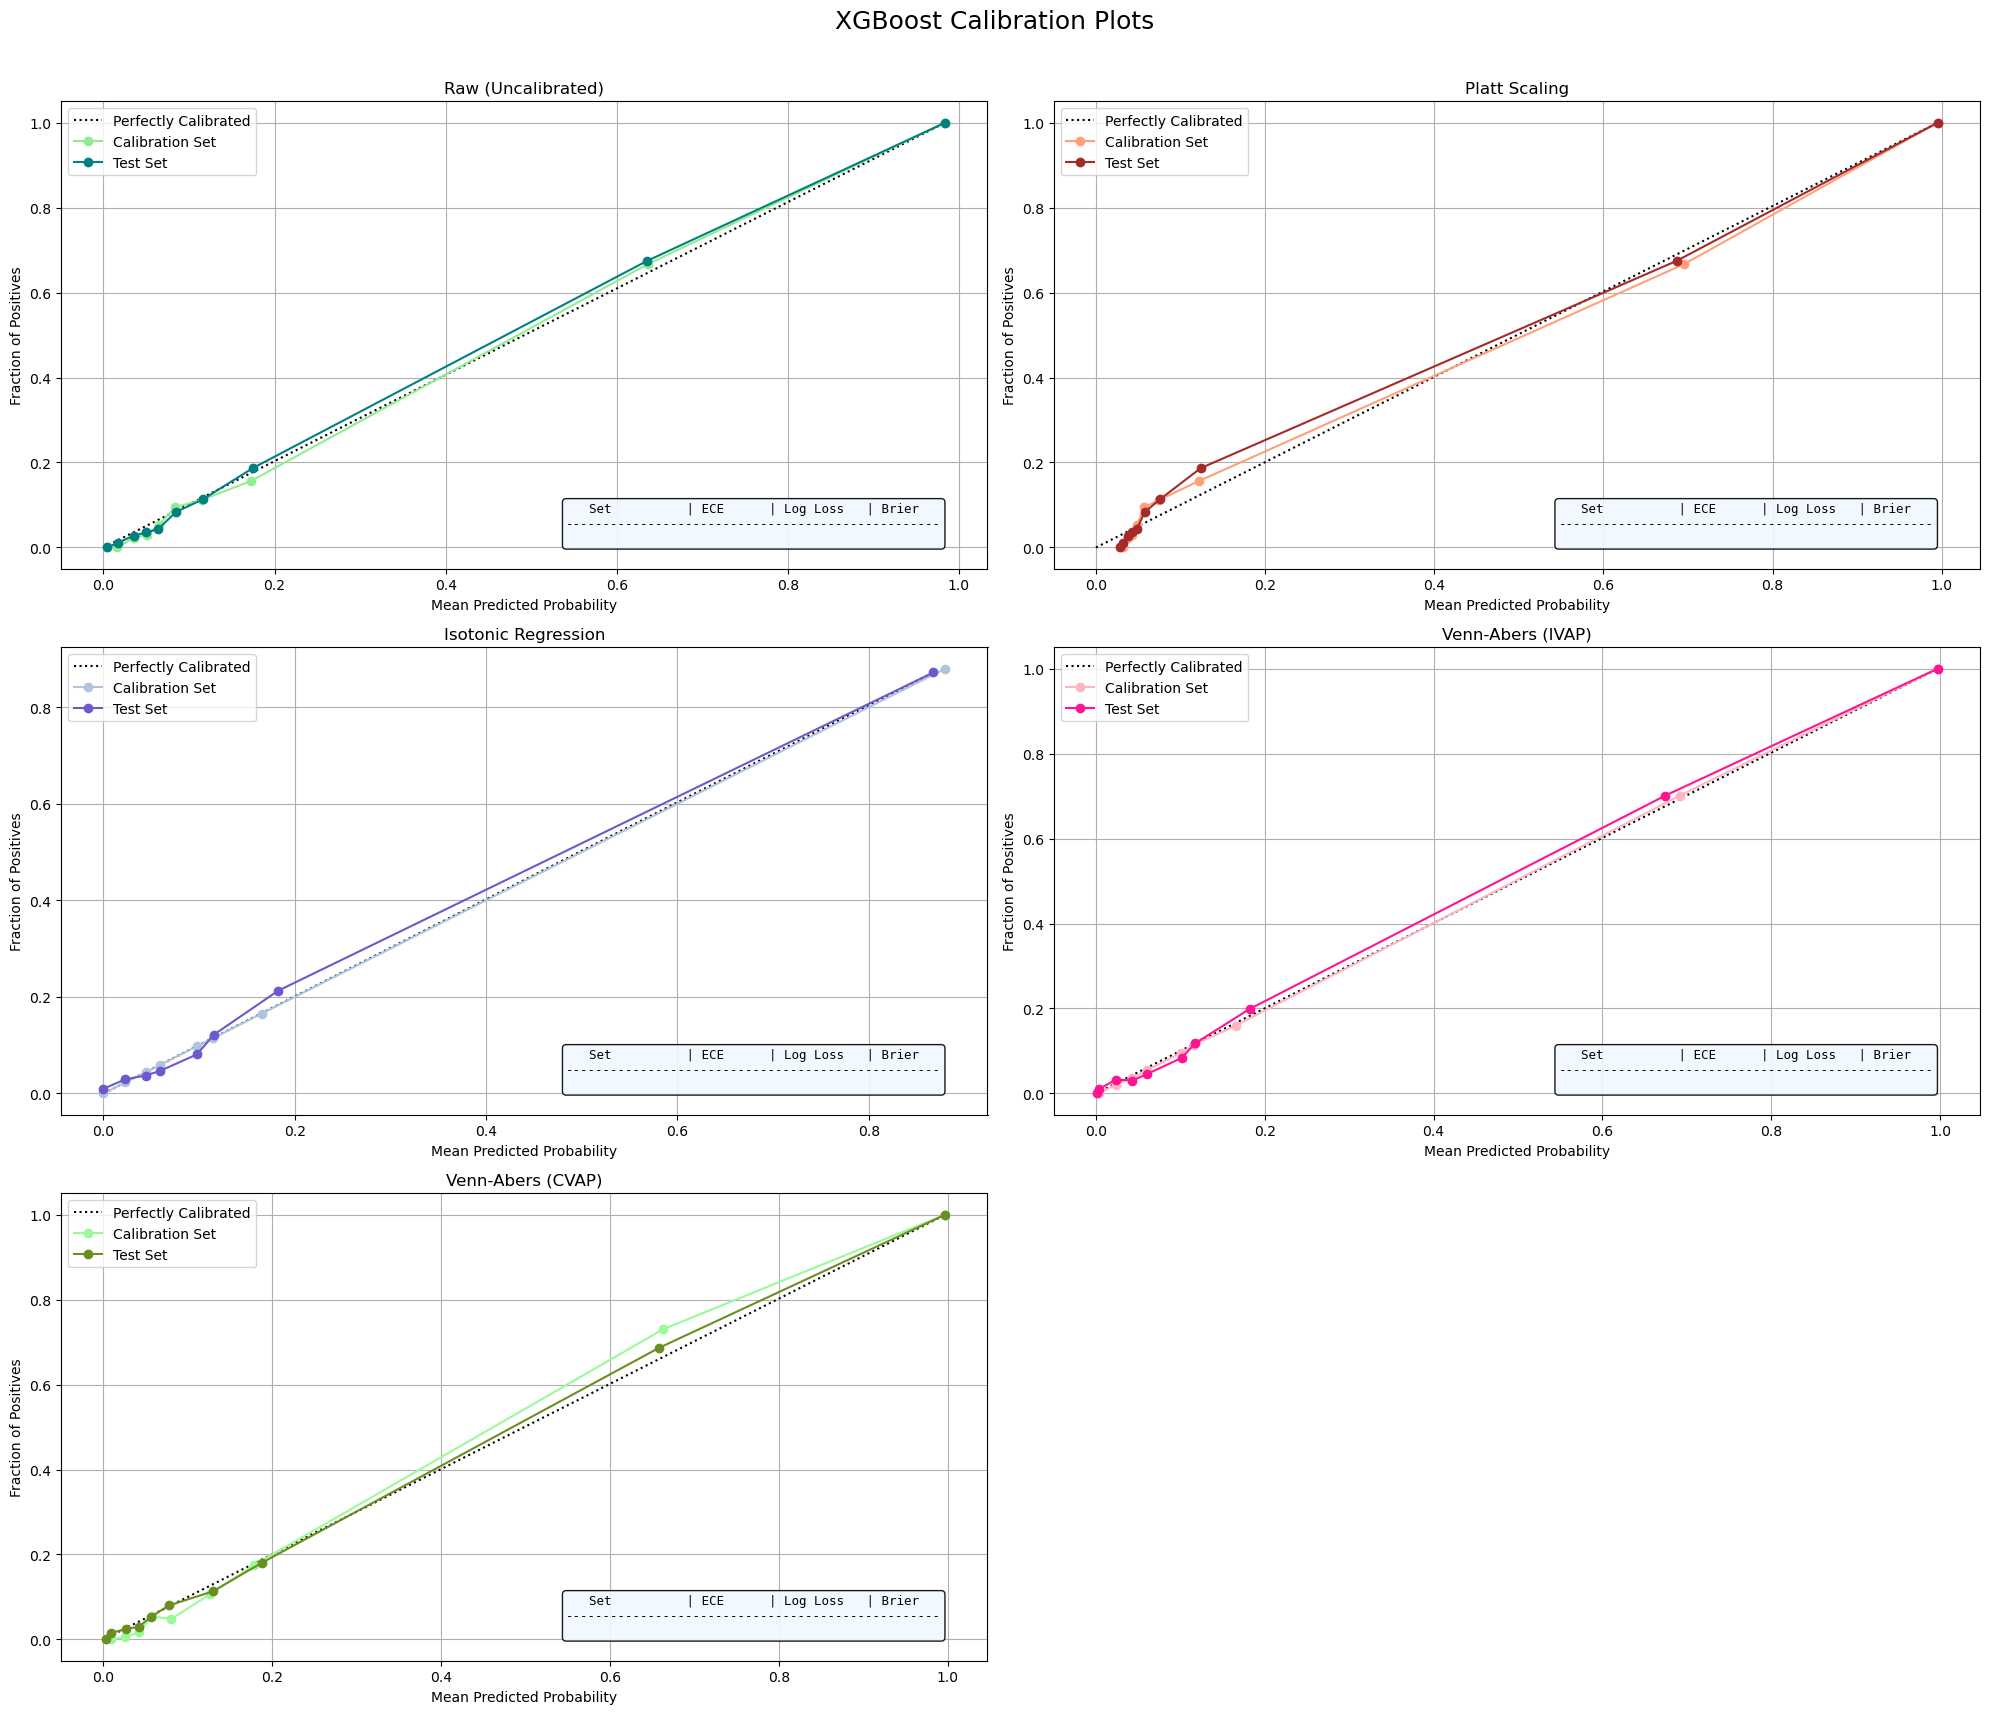

In [38]:
# Assuming 'test', 'calibration_perf_test', and 'calibration_perf_valid' DataFrames are available

# --- 1. Prepare both metrics DataFrames by setting the index ---
# calibration_perf_test.set_index('Method', inplace=True)
# calibration_perf_valid.set_index('Method', inplace=True)

# --- Define model suffixes and their properties for plotting ---
model_map = {
    'raw_prob': 'Raw (Uncalibrated)',
    'platt_prob': 'Platt Scaling',
    'iso_prob': 'Isotonic Regression',
    'venn_ivap': 'Venn-Abers (IVAP)',
    'venn_cvap': 'Venn-Abers (CVAP)'
}
colors = {
    'raw_prob': ['teal', 'lightgreen'],
    'platt_prob': ['brown', 'lightsalmon'],
    'iso_prob': ['slateblue', 'lightsteelblue'],
    'venn_ivap': ['deeppink', 'lightpink'],
    'venn_cvap': ['olivedrab', 'palegreen']
}

# --- Outer loop to create a separate figure for each base model ---
for node in ['lr', 'xgb']:
    
    fig, axs = plt.subplots(3, 2, figsize=(20, 18))
    axs = axs.flatten()
    fig.suptitle(f'{"Logistic Regression" if node=="lr" else "XGBoost"} Calibration Plots', fontsize=18)

    # --- Inner loop to create a plot for each model type ---
    for i, model_suffix in enumerate(model_map.keys()):
        ax = axs[i]
        col_name = f'{node}_{model_suffix}'
        model_name = model_map[model_suffix]

        if col_name in test.columns:
            # Plotting logic remains the same
            fraction_of_positives_val, mean_predicted_value_val = calibration_curve(
                valid['loan_status'], valid[col_name], n_bins=10, strategy='quantile'
            )
            
            fraction_of_positives, mean_predicted_value = calibration_curve(
                test['loan_status'], test[col_name], n_bins=10, strategy='quantile'
            )
            
            ax.plot([0, max(mean_predicted_value)], [0, max(fraction_of_positives)], 'k:', label='Perfectly Calibrated')
            ax.plot(mean_predicted_value_val, fraction_of_positives_val, marker='o', label='Calibration Set', color=colors[model_suffix][1])
            ax.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Test Set', color=colors[model_suffix][0])

            ax.set_title(model_name)
            ax.set_xlabel('Mean Predicted Probability')
            ax.set_ylabel('Fraction of Positives')
            ax.legend()
            ax.grid(True)

            # --- MODIFIED SECTION: Add metrics table for both sets ---
            metric_key = f'{node}_{model_suffix}'
            
            # Initialize metrics_text with a header
            metrics_text = f'{"Set":<12} | {"ECE":<8} | {"Log Loss":<10} | {"Brier":<8}\n'
            metrics_text += "-" * 50 + "\n"
            
            # Get and format VALIDATION metrics
            if metric_key in calibration_perf_valid.index:
                valid_metrics = calibration_perf_valid.loc[metric_key]
                metrics_text += (f'{"Validation":<12} | {valid_metrics["ECE"]:<8.4f} | '
                                 f'{valid_metrics["Log Loss"]:<10.4f} | {valid_metrics["Brier Score"]:<8.4f}\n')

            # Get and format TEST metrics
            if metric_key in calibration_perf_test.index:
                test_metrics = calibration_perf_test.loc[metric_key]
                metrics_text += (f'{"Test":<12} | {test_metrics["ECE"]:<8.4f} | '
                                 f'{test_metrics["Log Loss"]:<10.4f} | {test_metrics["Brier Score"]:<8.4f}')
            
            bbox_props = dict(boxstyle='round,pad=0.3', fc='aliceblue', alpha=0.9)
            
            # Add the text box to the subplot
            ax.text(0.95, 0.05, metrics_text, transform=ax.transAxes, fontsize=9,
                    verticalalignment='bottom', horizontalalignment='right', bbox=bbox_props, fontname='monospace')
            # --- End of Modified Section ---

        else:
            ax.text(0.5, 0.5, f'Column "{col_name}"\nnot found', 
                    ha='center', va='center', fontsize=12, color='red')
            ax.axis('off')

    # Hide any unused subplots
    if len(model_map) < len(axs):
        for j in range(len(model_map), len(axs)):
            fig.delaxes(axs[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

### *Calibration Charachteristics*

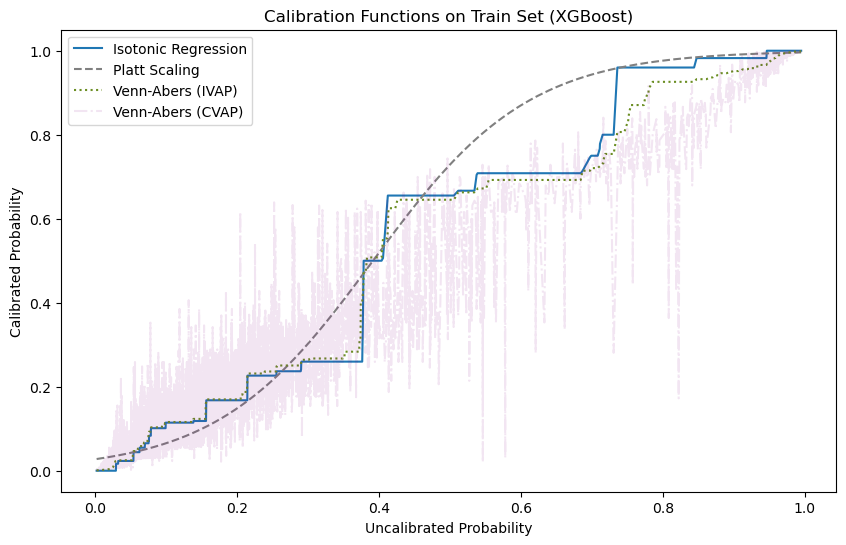

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train.sort_values('xgb_raw_prob')['xgb_raw_prob'], train.sort_values('xgb_raw_prob')['xgb_iso_prob'], label='Isotonic Regression')
plt.plot(train.sort_values('xgb_raw_prob')['xgb_raw_prob'], train.sort_values('xgb_raw_prob')['xgb_platt_prob'], linestyle='--', color='gray', label='Platt Scaling')
plt.plot(train.sort_values('xgb_raw_prob')['xgb_raw_prob'], train.sort_values('xgb_raw_prob')['xgb_venn_ivap'], linestyle=':', color='olivedrab', label='Venn-Abers (IVAP)')
plt.plot(train.sort_values('xgb_raw_prob')['xgb_raw_prob'], train.sort_values('xgb_raw_prob')['xgb_venn_cvap'], linestyle='-.', color='purple', label='Venn-Abers (CVAP)', alpha=0.1)
plt.xlabel('Uncalibrated Probability')
plt.ylabel('Calibrated Probability')
plt.title('Calibration Functions on Train Set (XGBoost)')
plt.legend()    
plt.show()

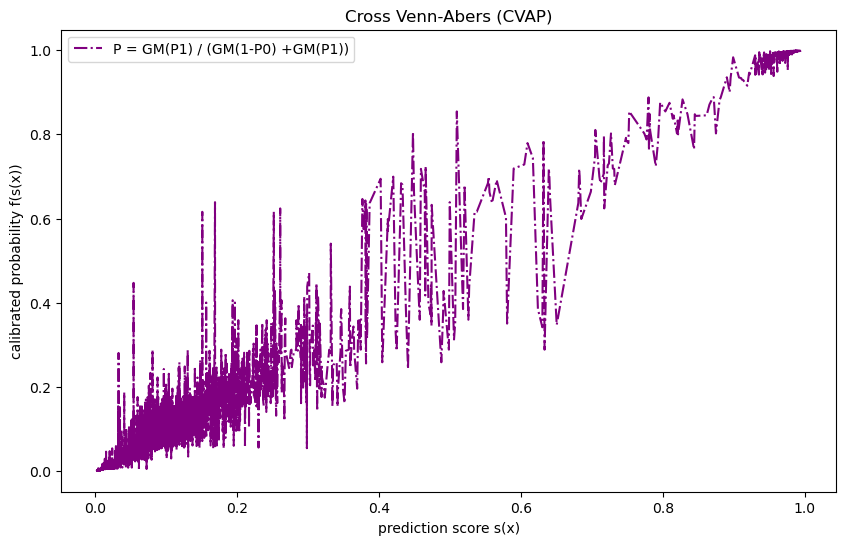

In [271]:
plt.figure(figsize=(10, 6))
# plt.plot(train.sort_values('xgb_raw_prob')['xgb_raw_prob'], train.sort_values('xgb_raw_prob')['xgb_iso_prob'], label='g(s(x))')
# plt.plot(train.sort_values('xgb_raw_prob')['xgb_raw_prob'], train.sort_values('xgb_raw_prob')['xgb_platt_prob'], linestyle='--', color='gray', label='g(s(x))')
# plt.plot(valid.sort_values('xgb_raw_prob')['xgb_raw_prob'], valid.sort_values('xgb_raw_prob')['xgb_venn_ivap'], linestyle='-', color='olivedrab', label='P = P1 / (1 - P0 + P1)')
# plt.plot(valid.sort_values('xgb_raw_prob')['xgb_raw_prob'], valid.sort_values('xgb_raw_prob')['xgb_p0_ivap'], linestyle='--', color='orange', label='P0')
# plt.plot(valid.sort_values('xgb_raw_prob')['xgb_raw_prob'], valid.sort_values('xgb_raw_prob')['xgb_p1_ivap'], linestyle='--', color='blue', label='P1')
plt.plot(valid.sort_values('xgb_raw_prob')['xgb_raw_prob'], valid.sort_values('xgb_raw_prob')['xgb_venn_cvap'], linestyle='-.', color='purple', label='P = GM(P1) / (GM(1-P0) +GM(P1))')#, alpha=0.1)
plt.xlabel('prediction score s(x)')
plt.ylabel('calibrated probability f(s(x))')
plt.title("Cross Venn-Abers (CVAP)")
plt.legend()    
plt.show()

# Interval Predictions

In [27]:
valid.head()

ID  xgb_raw_prob  xgb_platt_prob  xgb_iso_prob  xgb_venn_ivap  \
0   8881      0.412257        0.547426      0.655172       0.571429   
1  22262      0.097211        0.064115      0.101266       0.107867   
2  10162      0.140037        0.091911      0.118421       0.123377   
3  32333      0.058661        0.045996      0.044118       0.049366   
4  14369      0.003259        0.028277      0.000000       0.000973   

   xgb_p0_ivap  xgb_p1_ivap  xgb_venn_cvap  xgb_mean_p0_cvap  \
0     0.500000     0.666667       0.599018          0.556477   
1     0.101010     0.108696       0.106692          0.100109   
2     0.117647     0.124183       0.154612          0.151777   
3     0.043988     0.049645       0.038480          0.034587   
4     0.000000     0.000974       0.001840          0.000000   

   xgb_mean_p1_cvap  ...  lr_p0_ivap  lr_p1_ivap  lr_venn_cvap  \
0          0.652263  ...    0.208145    0.210407      0.264590   
1          0.108131  ...    0.538462    0.574324      0.515650   
2          0.155471  ...    0.573529    0.588235      0.568542   
3          0.040604  ...    0.065517    0.068966      0.080727   
4          0.001888  ...    0.000000    0.012658      0.013905   

   lr_mean_p0_cvap  lr_mean_p1_cvap  lr_min_p0_cvap  lr_max_p1_cvap  \
0         0.257335         0.269181        0.211823        0.307692   
1         0.508582         0.522907        0.465116        0.563830   
2         0.564401         0.573573        0.520231        0.600000   
3         0.078374         0.081135        0.068027        0.085399   
4         0.001695         0.014654        0.000000        0.020408   

   boot_lower_bound  boot_upper_bound  boot_mean_prob  
0          0.232438          0.391443        0.292649  
1          0.429534          0.578584        0.519704  
2          0.527208          0.643259        0.581138  
3          0.060168          0.102160        0.078981  
4          0.000000          0.012000        0.002338  

[5 rows x 27 columns]

In [28]:
# XGBoost width
valid['xgb_ivap_width'] = valid['xgb_p1_ivap'] - valid['xgb_p0_ivap']
valid['xgb_cvap_width_mean'] = valid['xgb_mean_p1_cvap'] - valid['xgb_mean_p0_cvap']
valid['xgb_cvap_width_minmax'] = valid['xgb_max_p1_cvap'] - valid['xgb_min_p0_cvap']

test['xgb_ivap_width'] = test['xgb_p1_ivap'] - test['xgb_p0_ivap']
test['xgb_cvap_width_mean'] = test['xgb_mean_p1_cvap'] - test['xgb_mean_p0_cvap']
test['xgb_cvap_width_minmax'] = test['xgb_max_p1_cvap'] - test['xgb_min_p0_cvap']

# Logistic Regression width
valid['lr_ivap_width'] = valid['lr_p1_ivap'] - valid['lr_p0_ivap']
valid['lr_cvap_width_mean'] = valid['lr_mean_p1_cvap'] - valid['lr_mean_p0_cvap']
valid['lr_cvap_width_minmax'] = valid['lr_max_p1_cvap'] - valid['lr_min_p0_cvap']   

test['lr_ivap_width'] = test['lr_p1_ivap'] - test['lr_p0_ivap']
test['lr_cvap_width_mean'] = test['lr_mean_p1_cvap'] - test['lr_mean_p0_cvap']
test['lr_cvap_width_minmax'] = test['lr_max_p1_cvap'] - test['lr_min_p0_cvap']

# Logistic regression bootstrap width
valid['lr_boot_width'] = valid['boot_upper_bound'] - valid['boot_lower_bound']
test['lr_boot_width'] = test['boot_upper_bound'] - test['boot_lower_bound']

## Analsysis

In [29]:
# Select only the width columns from your test dataframe
width_cols = [col for col in test.columns if '_width' in col]

# Calculate the mean for each width column
width_summary = test[width_cols].mean().reset_index()
width_summary.columns = ['Method', 'Average Interval Width']

# Sort for easier comparison
width_summary = width_summary.sort_values(by='Average Interval Width').reset_index(drop=True)

print("--- Average Interval Width on Test Set ---")
display(width_summary)

--- Average Interval Width on Test Set ---


Method  Average Interval Width
0         xgb_ivap_width                0.006686
1    xgb_cvap_width_mean                0.006909
2          lr_ivap_width                0.008043
3     lr_cvap_width_mean                0.008117
4  xgb_cvap_width_minmax                0.033290
5   lr_cvap_width_minmax                0.051418
6          lr_boot_width                0.062714

C:\Users\User\AppData\Local\Temp\ipykernel_2716\988021096.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sharpness_data = test.groupby('prob_bin')[[width_col]].mean().reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_2716\988021096.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sharpness_data = test.groupby('prob_bin')[[width_col]].mean().reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_2716\988021096.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=

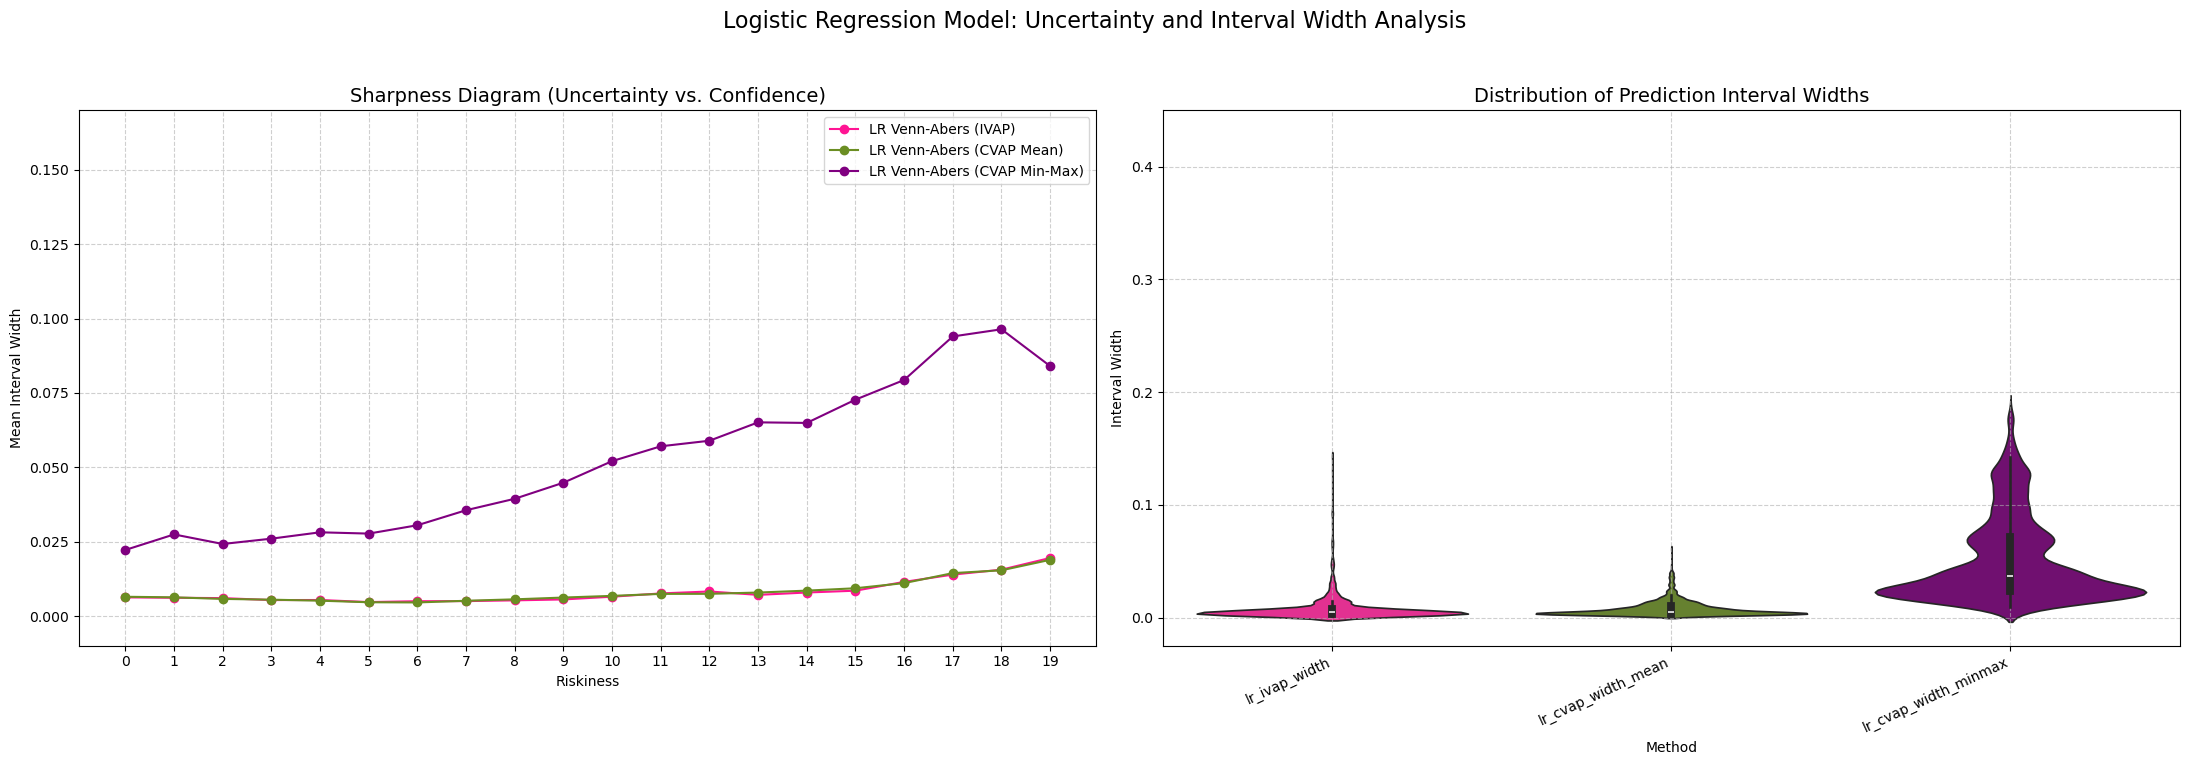

C:\Users\User\AppData\Local\Temp\ipykernel_2716\988021096.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sharpness_data = test.groupby('prob_bin')[[width_col]].mean().reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_2716\988021096.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sharpness_data = test.groupby('prob_bin')[[width_col]].mean().reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_2716\988021096.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=

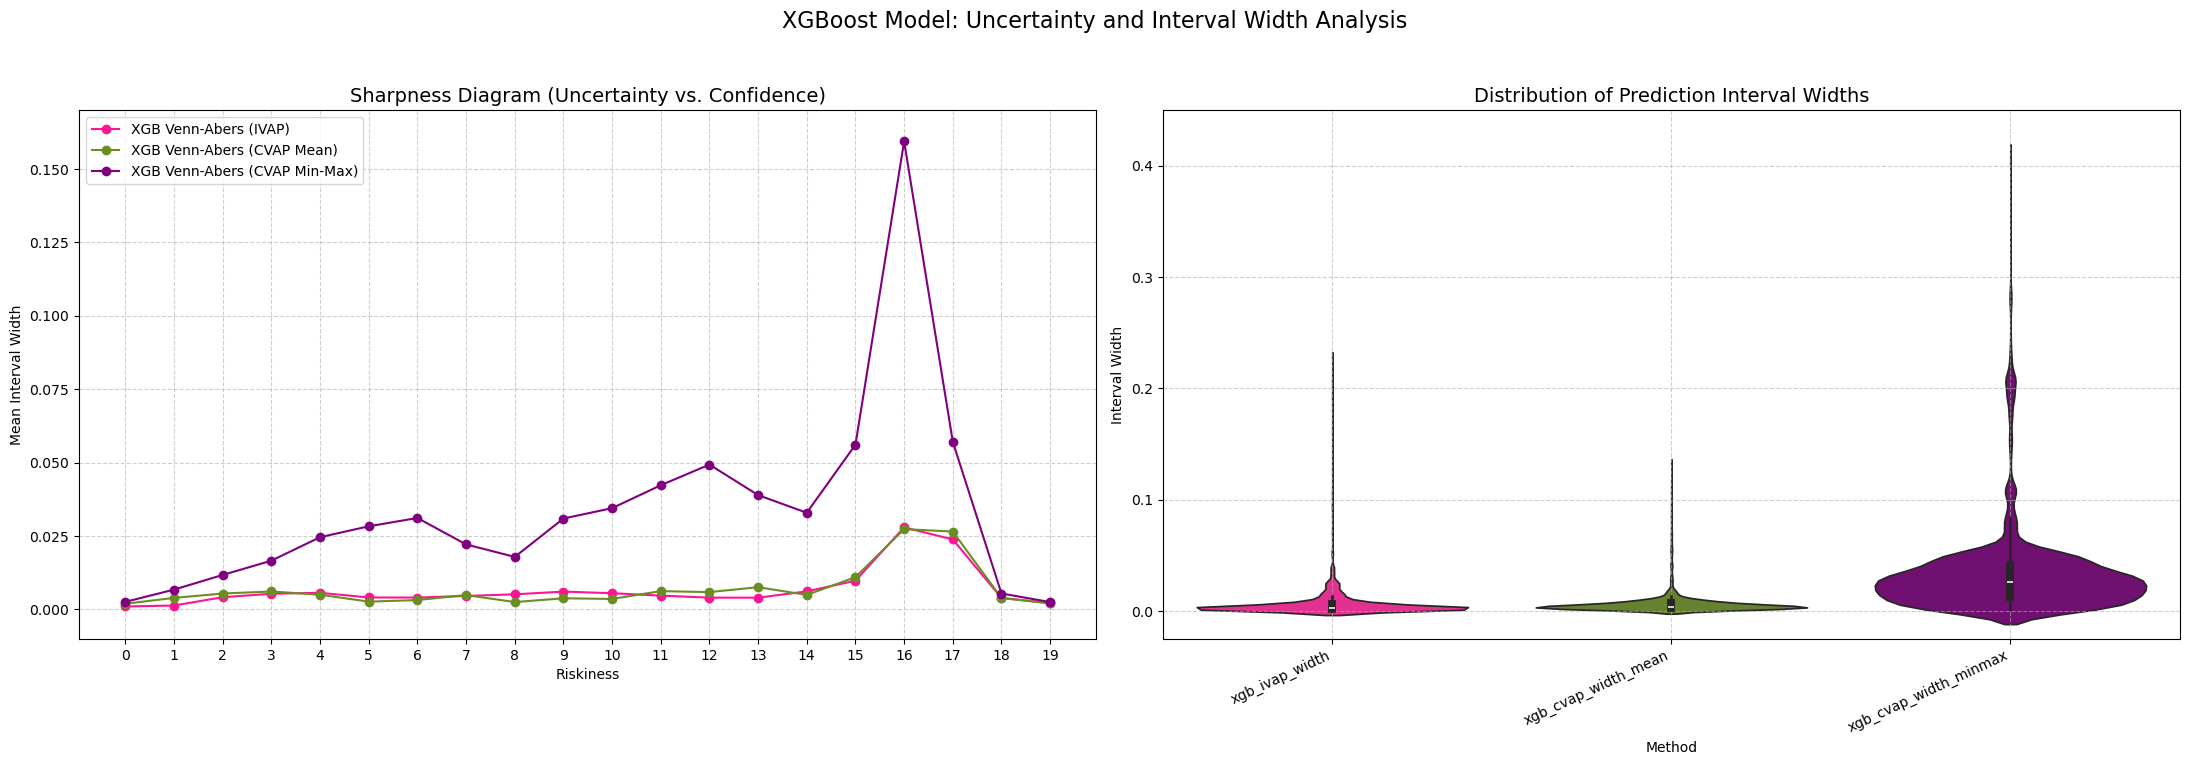

In [73]:
# Assuming 'test' and 'valid' DataFrames are loaded

# --- Define the methods to plot with their EXACT column names and consistent colors ---
# This dictionary drives the sharpness plot
method_definitions = {
    'xgb': [
        {
            'label': 'XGB Venn-Abers (IVAP)',
            # 'prob_col': 'xgb_venn_ivap',
            'prob_col': 'xgb_venn_cvap',
            'width_col': 'xgb_ivap_width',
            'color': 'deeppink'
        },
        {
            'label': 'XGB Venn-Abers (CVAP Mean)',
            'prob_col': 'xgb_venn_cvap',
            'width_col': 'xgb_cvap_width_mean',
            'color': 'olivedrab'
        },
        {
            'label': 'XGB Venn-Abers (CVAP Min-Max)',
            'prob_col': 'xgb_venn_cvap',
            'width_col': 'xgb_cvap_width_minmax',
            'color': 'purple'
        }
    ],
    'lr': [
        {
            'label': 'LR Venn-Abers (IVAP)',
            # 'prob_col': 'lr_venn_ivap',
            'prob_col': 'xgb_venn_cvap',
            'width_col': 'lr_ivap_width',
            'color': 'deeppink'
        },
        {
            'label': 'LR Venn-Abers (CVAP Mean)',
            'prob_col': 'xgb_venn_cvap',
            'width_col': 'lr_cvap_width_mean',
            'color': 'olivedrab'
        },
        {
            'label': 'LR Venn-Abers (CVAP Min-Max)',
            'prob_col': 'xgb_venn_cvap',
            'width_col': 'lr_cvap_width_minmax',
            'color': 'purple'
        },
        # {
        #     'label': 'LR Bootstrap',
        #     # 'prob_col': 'boot_mean_prob',
        #     'prob_col': 'lr_venn_cvap',
        #     'width_col': 'lr_boot_width',
        #     'color': 'saddlebrown'
        # }
    ]
}

# --- NEW: Create a color palette dictionary for the violin plot ---
# This maps the column names (which become categories) to the desired colors
color_palette = {
    'xgb_ivap_width': 'deeppink',
    'xgb_cvap_width_mean': 'olivedrab',
    'xgb_cvap_width_minmax': 'purple',
    'lr_ivap_width': 'deeppink',
    'lr_cvap_width_mean': 'olivedrab',
    'lr_cvap_width_minmax': 'purple',
    'lr_boot_width': 'saddlebrown'
}


# --- Loop to create a separate figure for each base model ---
for node in ['lr', 'xgb']:
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))
    title = 'Logistic Regression' if node == 'lr' else 'XGBoost'
    fig.suptitle(f'{title} Model: Uncertainty and Interval Width Analysis', fontsize=16)

    # --- Left Plot: Sharpness Diagram ---
    sharpness_methods = method_definitions[node]
    for method in sharpness_methods:
        prob_col, width_col = method['prob_col'], method['width_col']
        test['prob_bin'] = pd.qcut(test[prob_col], q=20, duplicates='drop')
        sharpness_data = test.groupby('prob_bin')[[width_col]].mean().reset_index()
        # print(f"Sharpness data for {method['label']}:")
        # print(sharpness_data)
        # sharpness_data['prob_bin'] = sharpness_data['prob_bin'].astype('str')

        # ax1.plot(sharpness_data['prob_bin'], sharpness_data[width_col], marker='o', 
        #          linestyle='-', label=method['label'], color=method['color'])
        ax1.plot(range(len(sharpness_data)), sharpness_data[width_col], marker='o', 
                 linestyle='-', label=method['label'], color=method['color'])

    ax1.set_title('Sharpness Diagram (Uncertainty vs. Confidence)', fontsize=14)
    # plt.setp(ax1.get_xticklabels(), rotation=25, ha="right")
    ax1.set_xlabel('Riskiness')
    ax1.set_ylabel('Mean Interval Width')
    ax1.set_ylim(-0.01, 0.17)
    ax1.set_xticks(range(20))
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend()

    # --- Right Plot: Violin Plots of Interval Widths ---
    if node == 'lr':
        width_cols_to_plot = ['lr_ivap_width', 'lr_cvap_width_mean', 'lr_cvap_width_minmax']#, 'lr_boot_width']
    else: # xgb
        width_cols_to_plot = ['xgb_ivap_width', 'xgb_cvap_width_mean', 'xgb_cvap_width_minmax']
    
    widths_df = test[width_cols_to_plot]
    widths_long = pd.melt(widths_df, var_name='Method', value_name='Interval Width')
    
    # --- MODIFIED LINE: Added the palette argument ---
    sns.violinplot(data=widths_long, x='Method', y='Interval Width', ax=ax2, palette=color_palette)
    
    ax2.set_title('Distribution of Prediction Interval Widths', fontsize=14)
    ax2.set_xlabel('Method')
    ax2.set_ylabel('Interval Width')
    ax2.set_ylim(-0.025, 0.45)
    plt.setp(ax2.get_xticklabels(), rotation=25, ha="right")
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

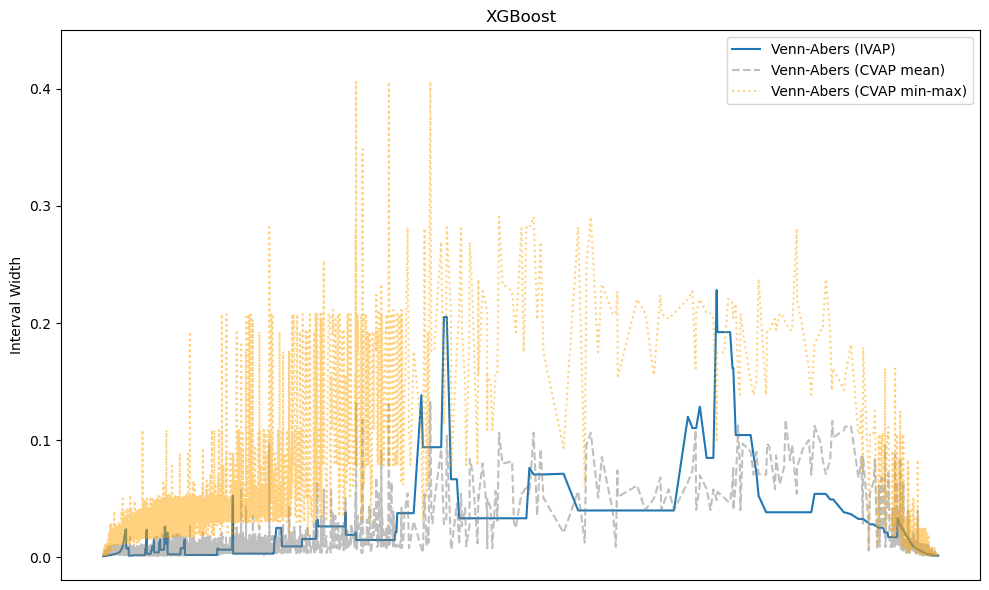

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(test.sort_values('xgb_raw_prob')['xgb_raw_prob'], test.sort_values('xgb_raw_prob')['xgb_ivap_width'], label='Venn-Abers (IVAP)')
plt.plot(test.sort_values('xgb_raw_prob')['xgb_raw_prob'], test.sort_values('xgb_raw_prob')['xgb_cvap_width_mean'], linestyle='--', color='gray', label='Venn-Abers (CVAP mean)', alpha=0.5)
plt.plot(test.sort_values('xgb_raw_prob')['xgb_raw_prob'], test.sort_values('xgb_raw_prob')['xgb_cvap_width_minmax'], linestyle=':', color='orange', label='Venn-Abers (CVAP min-max)', alpha=0.5)
# plt.plot(test.sort_values('xgb_raw_prob')['xgb_raw_prob'], test.sort_values('xgb_raw_prob')['Venn-Abers (CVAP)'], linestyle='-.', color='purple', label='Venn-Abers (CVAP)')
# plt.xlabel('Calibrated Probability')
plt.ylabel('Interval Width')
plt.title('XGBoost')
plt.xticks([])
plt.legend()
plt.ylim(top=0.45)
plt.tight_layout()
plt.show()

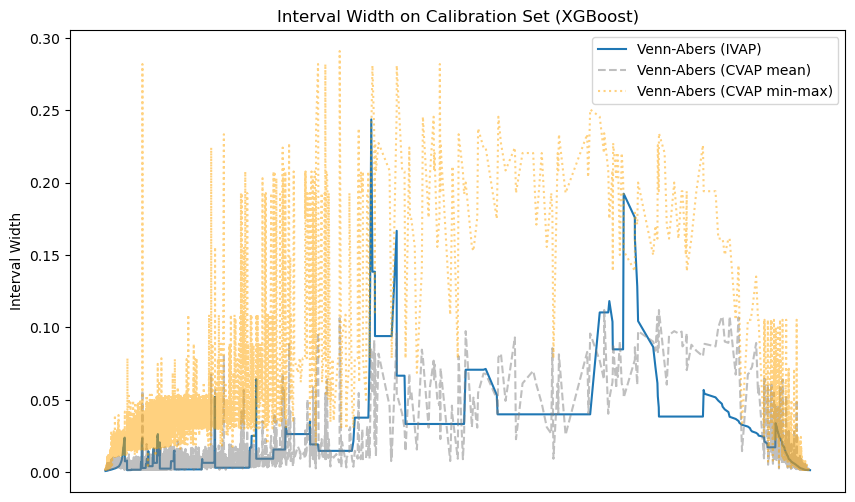

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(valid.sort_values('xgb_raw_prob')['xgb_raw_prob'], valid.sort_values('xgb_raw_prob')['xgb_ivap_width'], label='Venn-Abers (IVAP)')
plt.plot(valid.sort_values('xgb_raw_prob')['xgb_raw_prob'], valid.sort_values('xgb_raw_prob')['xgb_cvap_width_mean'], linestyle='--', color='gray', label='Venn-Abers (CVAP mean)', alpha=0.5)
plt.plot(valid.sort_values('xgb_raw_prob')['xgb_raw_prob'], valid.sort_values('xgb_raw_prob')['xgb_cvap_width_minmax'], linestyle=':', color='orange', label='Venn-Abers (CVAP min-max)', alpha=0.5)
# plt.xlabel('Calibrated Probability')
plt.ylabel('Interval Width')
plt.title('Interval Width on Calibration Set (XGBoost)')
plt.xticks([])
plt.legend()
plt.show()

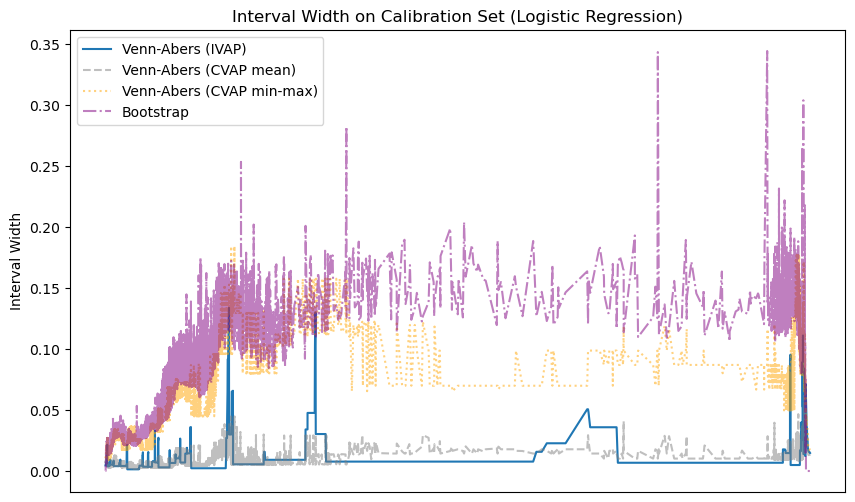

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(valid.sort_values('xgb_raw_prob')['xgb_raw_prob'], valid.sort_values('lr_raw_prob')['lr_ivap_width'], label='Venn-Abers (IVAP)')
plt.plot(valid.sort_values('xgb_raw_prob')['xgb_raw_prob'], valid.sort_values('lr_raw_prob')['lr_cvap_width_mean'], linestyle='--', color='gray', label='Venn-Abers (CVAP mean)', alpha=0.5)
plt.plot(valid.sort_values('xgb_raw_prob')['xgb_raw_prob'], valid.sort_values('lr_raw_prob')['lr_cvap_width_minmax'], linestyle=':', color='orange', label='Venn-Abers (CVAP min-max)', alpha=0.5)
plt.plot(valid.sort_values('xgb_raw_prob')['xgb_raw_prob'], valid.sort_values('lr_raw_prob')['lr_boot_width'], linestyle='-.', color='purple', label='Bootstrap', alpha=0.5)
# plt.xlabel('Calibrated Probability')
plt.ylabel('Interval Width')
plt.title('Interval Width on Calibration Set (Logistic Regression)')
plt.xticks([])
plt.legend()
plt.show()

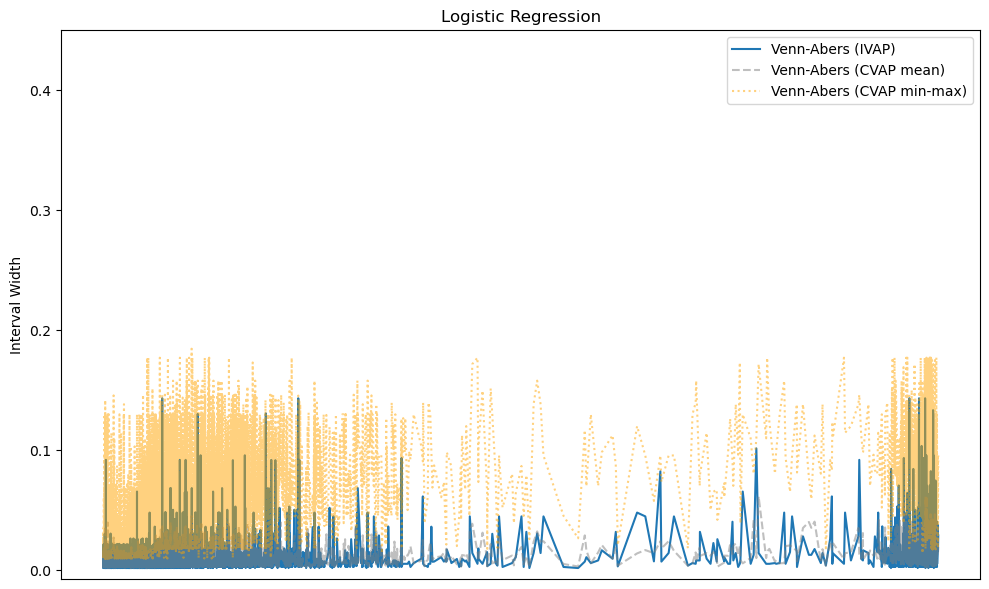

In [79]:
plt.figure(figsize=(10, 6))
plt.plot(test.sort_values('xgb_raw_prob')['xgb_raw_prob'], test.sort_values('xgb_raw_prob')['lr_ivap_width'], label='Venn-Abers (IVAP)')
plt.plot(test.sort_values('xgb_raw_prob')['xgb_raw_prob'], test.sort_values('xgb_raw_prob')['lr_cvap_width_mean'], linestyle='--', color='gray', label='Venn-Abers (CVAP mean)', alpha=0.5)
plt.plot(test.sort_values('xgb_raw_prob')['xgb_raw_prob'], test.sort_values('xgb_raw_prob')['lr_cvap_width_minmax'], linestyle=':', color='orange', label='Venn-Abers (CVAP min-max)', alpha=0.5)
# plt.plot(test.sort_values('xgb_raw_prob')['xgb_raw_prob'], test.sort_values('xgb_raw_prob')['lr_boot_width'], linestyle='-.', color='purple', label='Bootstrap', alpha=0.5)
# plt.xlabel('Calibrated Probability')
plt.xticks([])
plt.ylabel('Interval Width')
plt.title('Logistic Regression')
plt.legend()
plt.ylim(top=0.45)
plt.tight_layout()
plt.show()

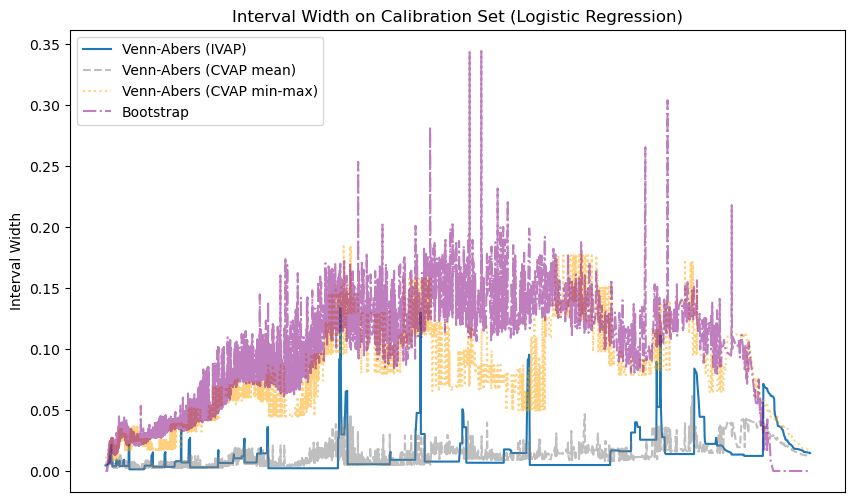

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(valid.sort_values('lr_raw_prob')['lr_raw_prob'], valid.sort_values('lr_raw_prob')['lr_ivap_width'], label='Venn-Abers (IVAP)')
plt.plot(valid.sort_values('lr_raw_prob')['lr_raw_prob'], valid.sort_values('lr_raw_prob')['lr_cvap_width_mean'], linestyle='--', color='gray', label='Venn-Abers (CVAP mean)', alpha=0.5)
plt.plot(valid.sort_values('lr_raw_prob')['lr_raw_prob'], valid.sort_values('lr_raw_prob')['lr_cvap_width_minmax'], linestyle=':', color='orange', label='Venn-Abers (CVAP min-max)', alpha=0.5)
plt.plot(valid.sort_values('lr_raw_prob')['lr_raw_prob'], valid.sort_values('lr_raw_prob')['lr_boot_width'], linestyle='-.', color='purple', label='Bootstrap', alpha=0.5)
# plt.xlabel('Calibrated Probability')
plt.ylabel('Interval Width')
plt.title('Interval Width on Calibration Set (Logistic Regression)')
plt.xticks([])
plt.legend()
plt.show()

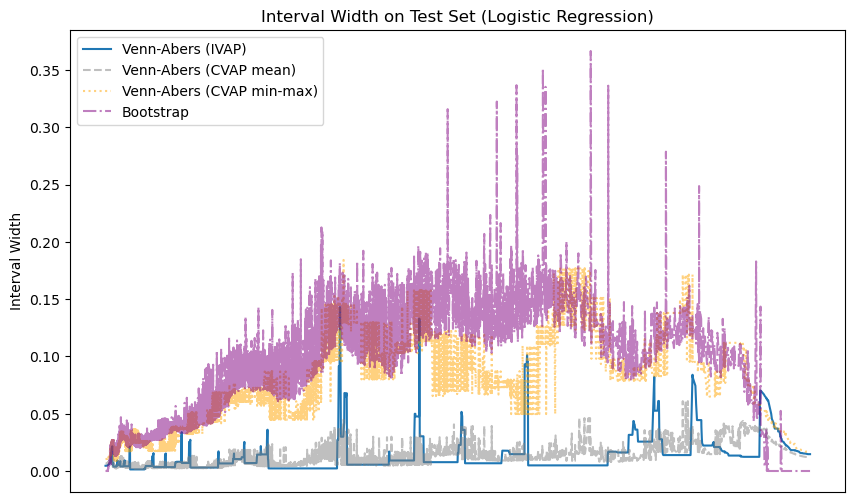

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(test.sort_values('lr_raw_prob')['lr_raw_prob'], test.sort_values('lr_raw_prob')['lr_ivap_width'], label='Venn-Abers (IVAP)')
plt.plot(test.sort_values('lr_raw_prob')['lr_raw_prob'], test.sort_values('lr_raw_prob')['lr_cvap_width_mean'], linestyle='--', color='gray', label='Venn-Abers (CVAP mean)', alpha=0.5)
plt.plot(test.sort_values('lr_raw_prob')['lr_raw_prob'], test.sort_values('lr_raw_prob')['lr_cvap_width_minmax'], linestyle=':', color='orange', label='Venn-Abers (CVAP min-max)', alpha=0.5)
plt.plot(test.sort_values('lr_raw_prob')['lr_raw_prob'], test.sort_values('lr_raw_prob')['lr_boot_width'], linestyle='-.', color='purple', label='Bootstrap', alpha=0.5)
# plt.xlabel('Calibrated Probability')
plt.xticks([])
plt.ylabel('Interval Width')
plt.title('Interval Width on Test Set (Logistic Regression)')
plt.legend()
plt.show()

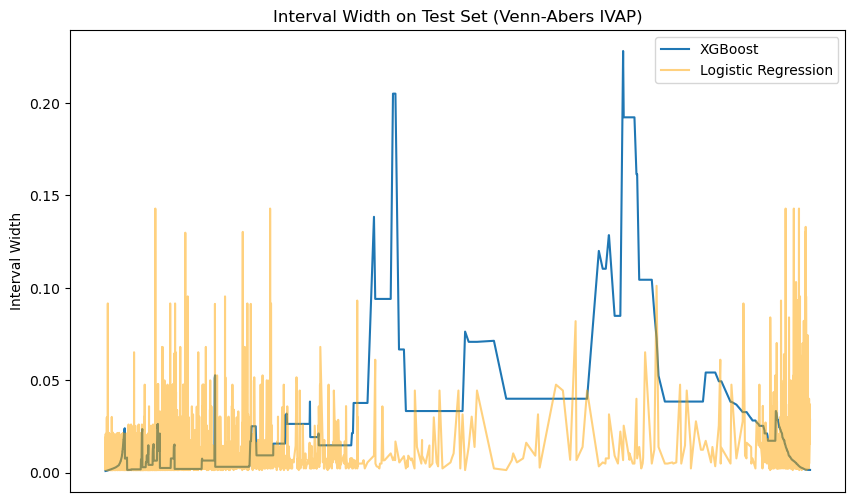

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(test.sort_values('xgb_raw_prob')['xgb_raw_prob'], test.sort_values('xgb_raw_prob')['xgb_ivap_width'], label='XGBoost')
plt.plot(test.sort_values('xgb_raw_prob')['xgb_raw_prob'], test.sort_values('xgb_raw_prob')['lr_ivap_width'], label='Logistic Regression', color='orange', alpha=0.5)
# turn off xticks
plt.xticks([])
plt.ylabel('Interval Width')
plt.title('Interval Width on Test Set (Venn-Abers IVAP)')
plt.legend()
plt.show()

In [67]:
test.columns

Index(['ID', 'xgb_raw_prob', 'xgb_platt_prob', 'xgb_iso_prob', 'xgb_venn_ivap',
       'xgb_p0_ivap', 'xgb_p1_ivap', 'xgb_venn_cvap', 'xgb_mean_p0_cvap',
       'xgb_mean_p1_cvap', 'xgb_min_p0_cvap', 'xgb_max_p1_cvap', 'loan_status',
       'lr_raw_prob', 'lr_platt_prob', 'lr_iso_prob', 'lr_venn_ivap',
       'lr_p0_ivap', 'lr_p1_ivap', 'lr_venn_cvap', 'lr_mean_p0_cvap',
       'lr_mean_p1_cvap', 'lr_min_p0_cvap', 'lr_max_p1_cvap',
       'boot_lower_bound', 'boot_upper_bound', 'boot_mean_prob',
       'xgb_ivap_width', 'xgb_cvap_width_mean', 'xgb_cvap_width_minmax',
       'lr_ivap_width', 'lr_cvap_width_mean', 'lr_cvap_width_minmax',
       'lr_boot_width', 'prob_bin'],
      dtype='object')

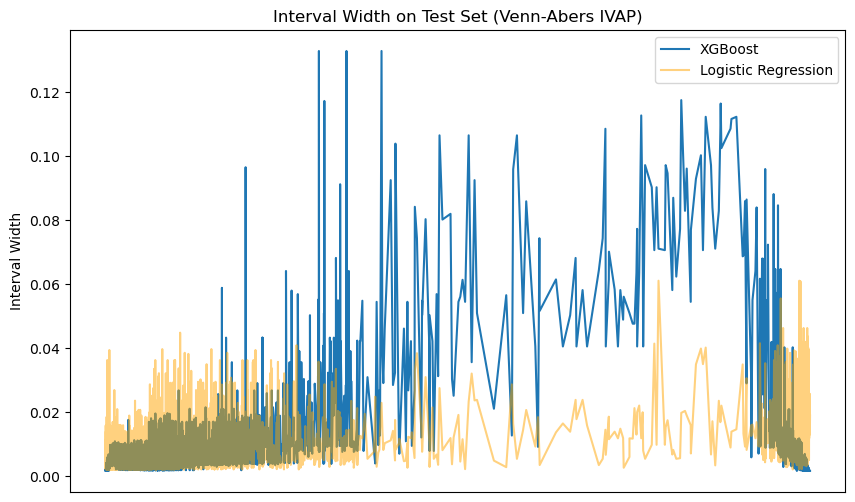

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(test.sort_values('xgb_raw_prob')['xgb_raw_prob'], test.sort_values('xgb_raw_prob')['xgb_cvap_width_mean'], label='XGBoost')
plt.plot(test.sort_values('xgb_raw_prob')['xgb_raw_prob'], test.sort_values('xgb_raw_prob')['lr_cvap_width_mean'], label='Logistic Regression', color='orange', alpha=0.5)
# turn off xticks
plt.xticks([])
plt.ylabel('Interval Width')
plt.title('Interval Width on Test Set (Venn-Abers IVAP)')
plt.legend()
plt.show()

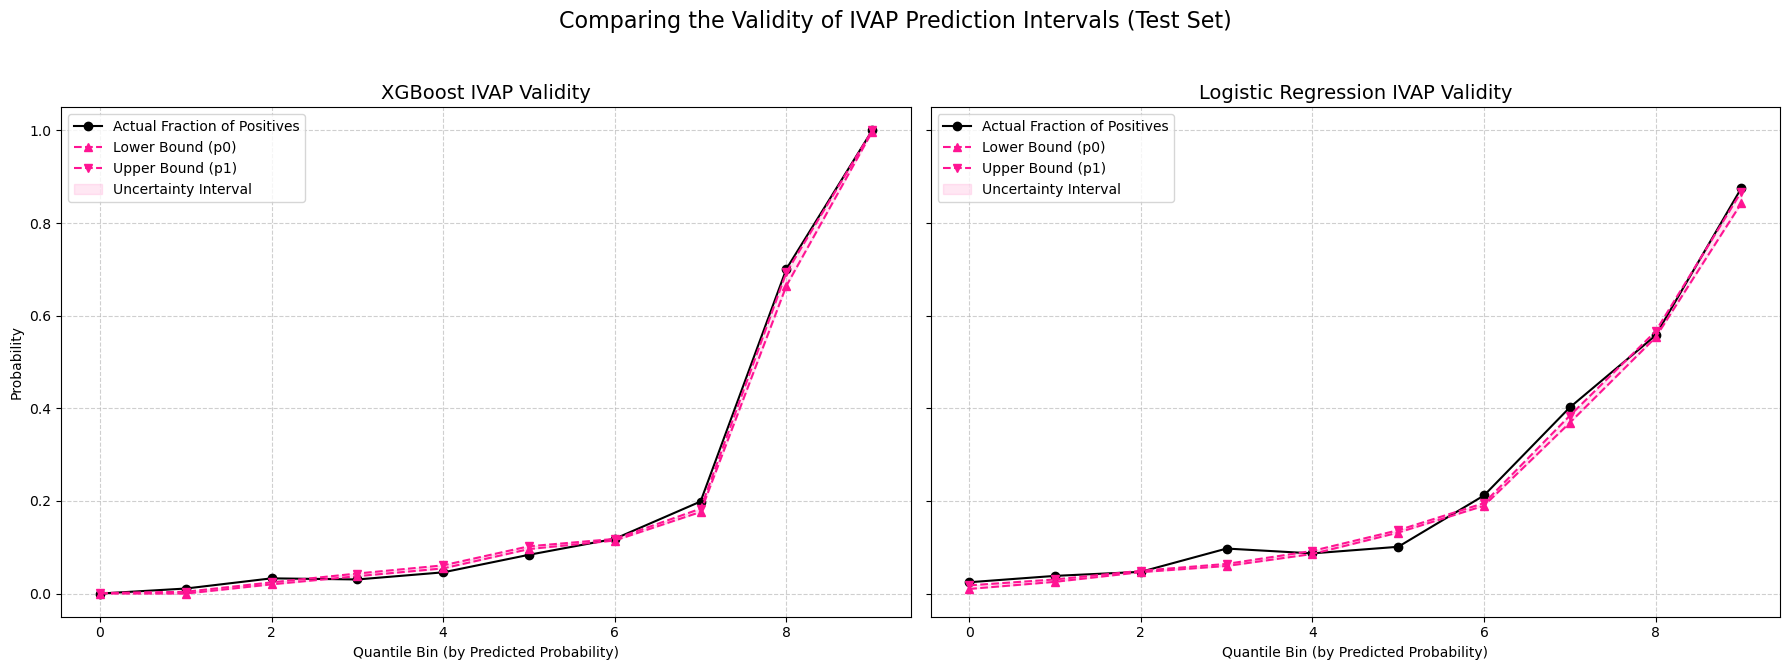

In [164]:
# Assuming 'test' DataFrame is loaded with all probability columns

# --- 1. Setup the figure with two subplots ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
fig.suptitle('Comparing the Validity of IVAP Prediction Intervals (Test Set)', fontsize=16)

# --- 2. Plot for XGBoost IVAP ---
xgb_p0_col = 'xgb_p0_ivap'
xgb_p1_col = 'xgb_p1_ivap'

# For binning, it's best to use the midpoint of the interval
test['xgb_ivap_bin'] = pd.qcut(test['xgb_venn_ivap'], q=10, labels=False, duplicates='drop')

# Group by the bins and calculate the mean of the bounds and the actual outcome
xgb_validity_data = test.groupby('xgb_ivap_bin')[[xgb_p0_col, xgb_p1_col, 'loan_status']].mean()

ax1.plot(xgb_validity_data.index, xgb_validity_data['loan_status'], 
         marker='o', linestyle='-', color='black', label='Actual Fraction of Positives')
ax1.plot(xgb_validity_data.index, xgb_validity_data[xgb_p0_col], 
         marker='^', linestyle='--', color='deeppink', label='Lower Bound (p0)')
ax1.plot(xgb_validity_data.index, xgb_validity_data[xgb_p1_col], 
         marker='v', linestyle='--', color='deeppink', label='Upper Bound (p1)')

# Shade the area between the bounds to represent the uncertainty channel
ax1.fill_between(xgb_validity_data.index, xgb_validity_data[xgb_p0_col], xgb_validity_data[xgb_p1_col], 
                 color='deeppink', alpha=0.1, label='Uncertainty Interval')

ax1.set_title('XGBoost IVAP Validity', fontsize=14)
ax1.set_xlabel('Quantile Bin (by Predicted Probability)')
ax1.set_ylabel('Probability')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend()

# --- 3. Plot for Logistic Regression IVAP ---
lr_p0_col = 'lr_p0_ivap'
lr_p1_col = 'lr_p1_ivap'

# Create bins for the LR model
test['lr_ivap_bin'] = pd.qcut(test['lr_venn_ivap'], q=10, labels=False, duplicates='drop')
lr_validity_data = test.groupby('lr_ivap_bin')[[lr_p0_col, lr_p1_col, 'loan_status']].mean()

ax2.plot(lr_validity_data.index, lr_validity_data['loan_status'], 
         marker='o', linestyle='-', color='black', label='Actual Fraction of Positives')
ax2.plot(lr_validity_data.index, lr_validity_data[lr_p0_col], 
         marker='^', linestyle='--', color='deeppink', label='Lower Bound (p0)')
ax2.plot(lr_validity_data.index, lr_validity_data[lr_p1_col], 
         marker='v', linestyle='--', color='deeppink', label='Upper Bound (p1)')

# Shade the area
ax2.fill_between(lr_validity_data.index, lr_validity_data[lr_p0_col], lr_validity_data[lr_p1_col], 
                 color='deeppink', alpha=0.1, label='Uncertainty Interval')

ax2.set_title('Logistic Regression IVAP Validity', fontsize=14)
ax2.set_xlabel('Quantile Bin (by Predicted Probability)')
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# calculate destoyed validity for XGBoost IVAP
xgb_destr_validity = np.mean((xgb_validity_data['loan_status'] < xgb_validity_data['xgb_p0_ivap']) | 
                              (xgb_validity_data['loan_status'] > xgb_validity_data['xgb_p1_ivap']))

# calculate destoyed validity for Logistic Regression IVAP
lr_destr_validity = np.mean((lr_validity_data['loan_status'] < lr_validity_data['lr_p0_ivap']) | 
                              (lr_validity_data['loan_status'] > lr_validity_data['lr_p1_ivap']))


In [186]:
# For a given DataFrame `df` with true labels 'y_true' and interval columns 'lower_bound', 'upper_bound'
def calculate_coverage(df):
    conditions = [
        (df['y_true'] == 1) & (df['upper_bound'] >= 0.5),
        (df['y_true'] == 0) & (df['lower_bound'] < 0.5)
    ]
    cover = np.select(conditions, [1, 1], default=0)
    empirical_coverage = cover.mean()
    return empirical_coverage

# Example: Calculate coverage for your Logistic Regression + IVAP method
xgb_ivap_coverage = calculate_coverage(test.rename(columns={
    'loan_status': 'y_true',
    'xgb_p0_ivap': 'lower_bound',  # Replace with your actual column names
    'xgb_p1_ivap': 'upper_bound'
}))

xgb_cvap_coverage = calculate_coverage(test.rename(columns={
    'loan_status': 'y_true',
    'xgb_mean_p0_cvap': 'lower_bound',  # Replace with your actual column names
    'xgb_mean_p1_cvap': 'upper_bound'
}))

xgb_cvap_coverage_minmax = calculate_coverage(test.rename(columns={
    'loan_status': 'y_true',
    'xgb_min_p0_cvap': 'lower_bound',  # Replace with your actual column names
    'xgb_max_p1_cvap': 'upper_bound'
}))


lr_ivap_coverage = calculate_coverage(test.rename(columns={
    'loan_status': 'y_true',
    'lr_p0_ivap': 'lower_bound',  # Replace with your actual column names
    'lr_p1_ivap': 'upper_bound'
}))

lr_cvap_coverage = calculate_coverage(test.rename(columns={
    'loan_status': 'y_true',
    'lr_mean_p0_cvap': 'lower_bound',  # Replace with your actual column names
    'lr_mean_p1_cvap': 'upper_bound'
}))

lr_cvap_coverage_minmax = calculate_coverage(test.rename(columns={
    'loan_status': 'y_true',
    'lr_min_p0_cvap': 'lower_bound',  # Replace with your actual column names
    'lr_max_p1_cvap': 'upper_bound'
}))

lr_boot_coverage = calculate_coverage(test.rename(columns={
    'loan_status': 'y_true',
    'boot_lower_bound': 'lower_bound',  # Replace with your actual column names
    'boot_upper_bound': 'upper_bound'
}))

print(f"XGBoost + IVAP Coverage: {xgb_ivap_coverage:.3%}")
print(f"XGBoost + CVAP Coverage: {xgb_cvap_coverage:.3%}")
print(f"XGBoost + CVAP (Min-Max) Coverage: {xgb_cvap_coverage_minmax:.3%}")
print(f"Logistic Regression + IVAP Coverage: {lr_ivap_coverage:.3%}")
print(f"Logistic Regression + CVAP Coverage: {lr_cvap_coverage:.3%}")
print(f"Logistic Regression + CVAP (Min-Max) Coverage: {lr_cvap_coverage_minmax:.3%}")
print(f"Logistic Regression + Bootstrap Coverage: {lr_boot_coverage:.3%}")

XGBoost + IVAP Coverage: 93.322%
XGBoost + CVAP Coverage: 93.430%
XGBoost + CVAP (Min-Max) Coverage: 93.538%
Logistic Regression + IVAP Coverage: 85.025%
Logistic Regression + CVAP Coverage: 85.441%
Logistic Regression + CVAP (Min-Max) Coverage: 86.752%
Logistic Regression + Bootstrap Coverage: 87.770%


In [173]:
test[test['xgb_venn_ivap']>=0.5]['loan_status'].value_counts(normalize=True)

loan_status
1    0.962786
0    0.037214
Name: proportion, dtype: float64

In [182]:
test[test['loan_status']==1]['xgb_venn_ivap'].describe([0.1, 0.2, 0.27, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

count    1411.000000
mean        0.736837
std         0.382484
min         0.002075
10%         0.116000
20%         0.169811
27%         0.267238
30%         0.659341
40%         0.974359
50%         0.992537
60%         0.995708
70%         0.997214
80%         0.997849
90%         0.998333
max         0.998542
Name: xgb_venn_ivap, dtype: float64

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test.sort_values('lr_raw_prob')['lr_raw_prob'], test.sort_values('lr_raw_prob')['lr_ivap_width'], label='Venn-Abers (IVAP)')

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

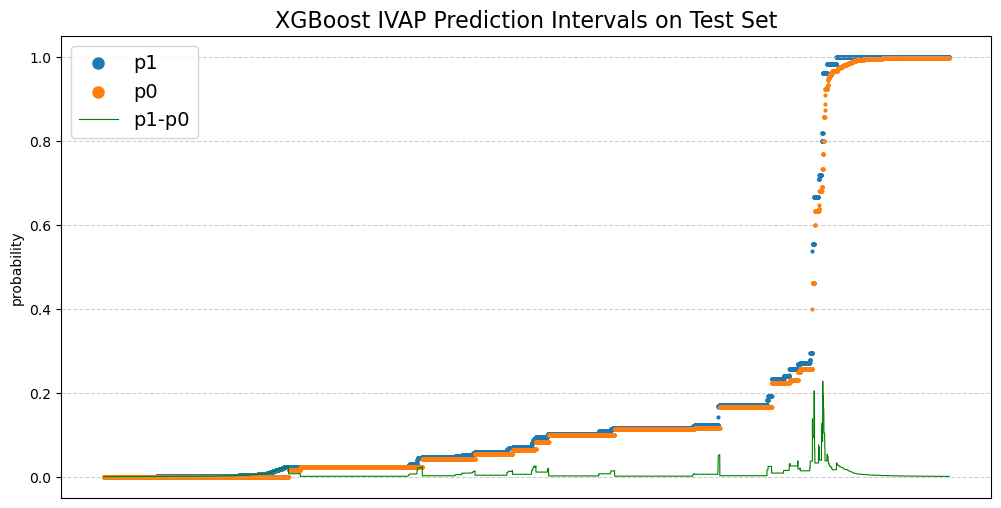

In [46]:
# xgboost ivap test set
predictions = test.sort_values(by=['xgb_raw_prob'])
predictions = predictions.reset_index()

plt.figure(figsize=(12, 6))
plt.scatter(x=predictions.index,y=predictions["xgb_p1_ivap"],label="p1",s=4)
plt.scatter(x=predictions.index,y=predictions["xgb_p0_ivap"],label="p0",s=4)
plt.plot(predictions.index, predictions["xgb_ivap_width"],label="p1-p0",lw=0.8,color="green")
plt.legend(loc="upper left",fontsize=14, scatterpoints=1, markerscale=4)
plt.ylabel("probability")
plt.title("XGBoost IVAP Prediction Intervals on Test Set", fontsize=16)
plt.xticks([])
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

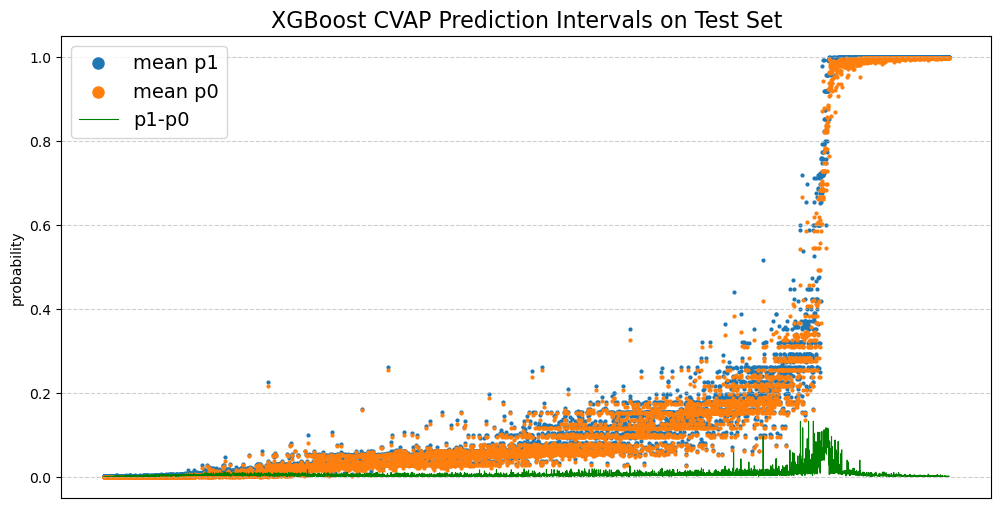

In [194]:
# xgboost cvap test set
predictions = test.sort_values(by=['xgb_raw_prob'])
predictions = predictions.reset_index()

plt.figure(figsize=(12, 6))
plt.scatter(x=predictions.index,y=predictions["xgb_mean_p1_cvap"],label="mean p1",s=4)
plt.scatter(x=predictions.index,y=predictions["xgb_mean_p0_cvap"],label="mean p0",s=4)
plt.plot(predictions.index, predictions["xgb_cvap_width_mean"],label="p1-p0",lw=0.8,color="green")
plt.legend(loc="upper left",fontsize=14, scatterpoints=1, markerscale=4)
plt.ylabel("probability")
plt.title("XGBoost CVAP Prediction Intervals on Test Set", fontsize=16)
plt.xticks([])
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

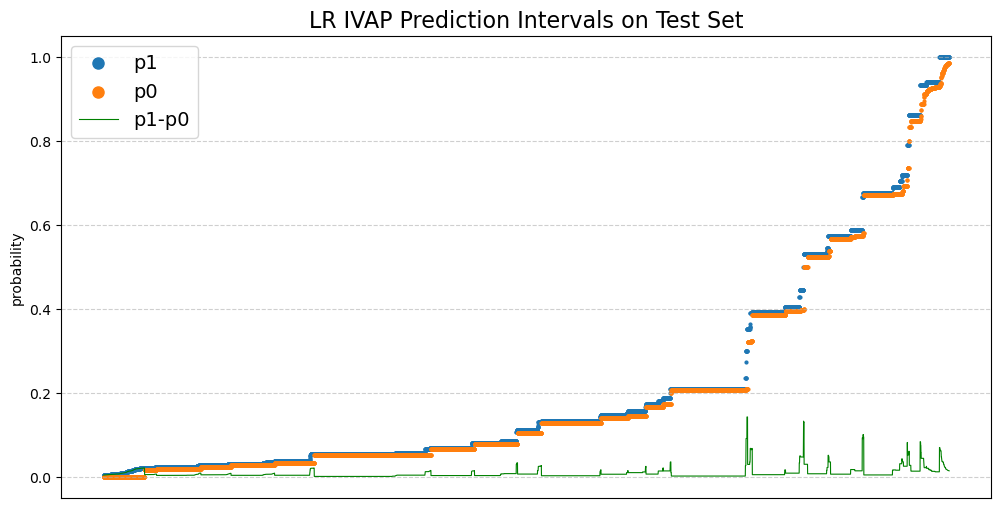

In [195]:
# LR ivap test set
predictions = test.sort_values(by=['lr_raw_prob'])
predictions = predictions.reset_index()

plt.figure(figsize=(12, 6))
plt.scatter(x=predictions.index,y=predictions["lr_p1_ivap"],label="p1",s=4)
plt.scatter(x=predictions.index,y=predictions["lr_p0_ivap"],label="p0",s=4)
plt.plot(predictions.index, predictions["lr_ivap_width"],label="p1-p0",lw=0.8,color="green")
plt.legend(loc="upper left",fontsize=14, scatterpoints=1, markerscale=4)
plt.ylabel("probability")
plt.title("LR IVAP Prediction Intervals on Test Set", fontsize=16)
plt.xticks([])
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


--- Visualizing CDF of Prediction Intervals ---


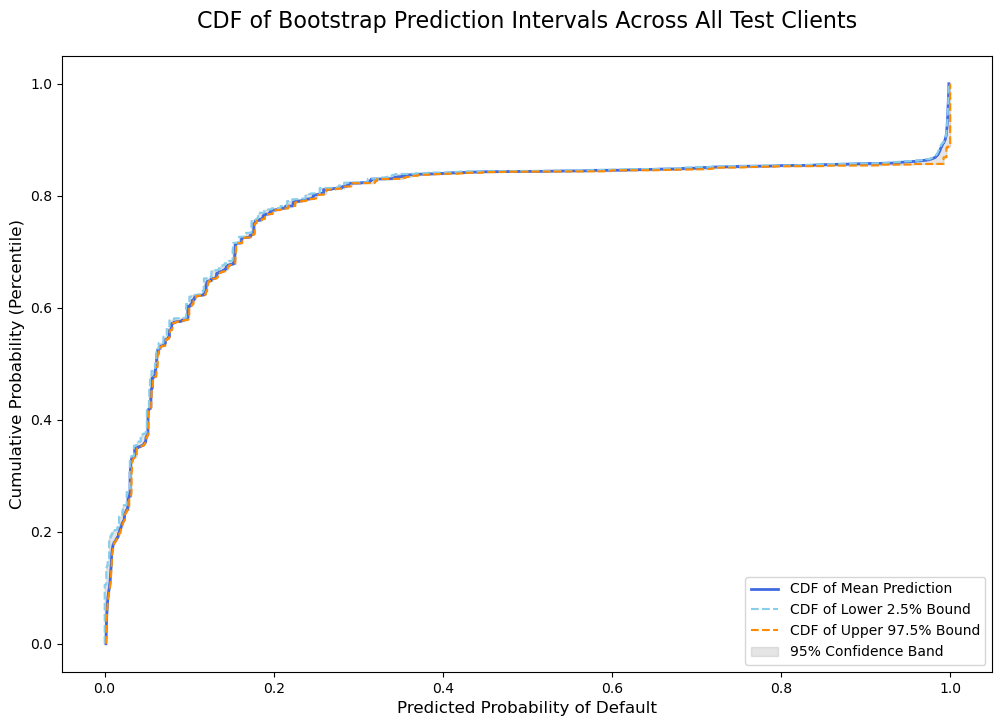

In [ ]:
# We will plot the CDF for the mean predictions, and the lower/upper bounds
mean_probs_sorted = np.sort(test['xgb_venn_cvap'])  # or 'lr_venn_cvap' for Logistic Regression
lower_bounds_sorted = np.sort(test['xgb_mean_p0_cvap'])
upper_bounds_sorted = np.sort(test['xgb_mean_p1_cvap'])

# The y-axis for a CDF is the percentile, from 0 to 1
y_axis = np.linspace(0, 1, len(test))

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the three CDFs
ax.plot(mean_probs_sorted, y_axis, label='CDF of Mean Prediction', color='royalblue', linewidth=2)
ax.plot(lower_bounds_sorted, y_axis, label='CDF of Lower 2.5% Bound', color='skyblue', linestyle='--')
ax.plot(upper_bounds_sorted, y_axis, label='CDF of Upper 97.5% Bound', color='darkorange', linestyle='--')

# Add shading to represent the 95% confidence interval band
ax.fill_betweenx(y_axis, lower_bounds_sorted, upper_bounds_sorted, color='gray', alpha=0.2, label='95% Confidence Band')

ax.set_title('CDF of Bootstrap Prediction Intervals Across All Test Clients', fontsize=16, pad=20)
ax.set_xlabel('Predicted Probability of Default', fontsize=12)
ax.set_ylabel('Cumulative Probability (Percentile)', fontsize=12)
ax.legend(loc='lower right')
plt.show()


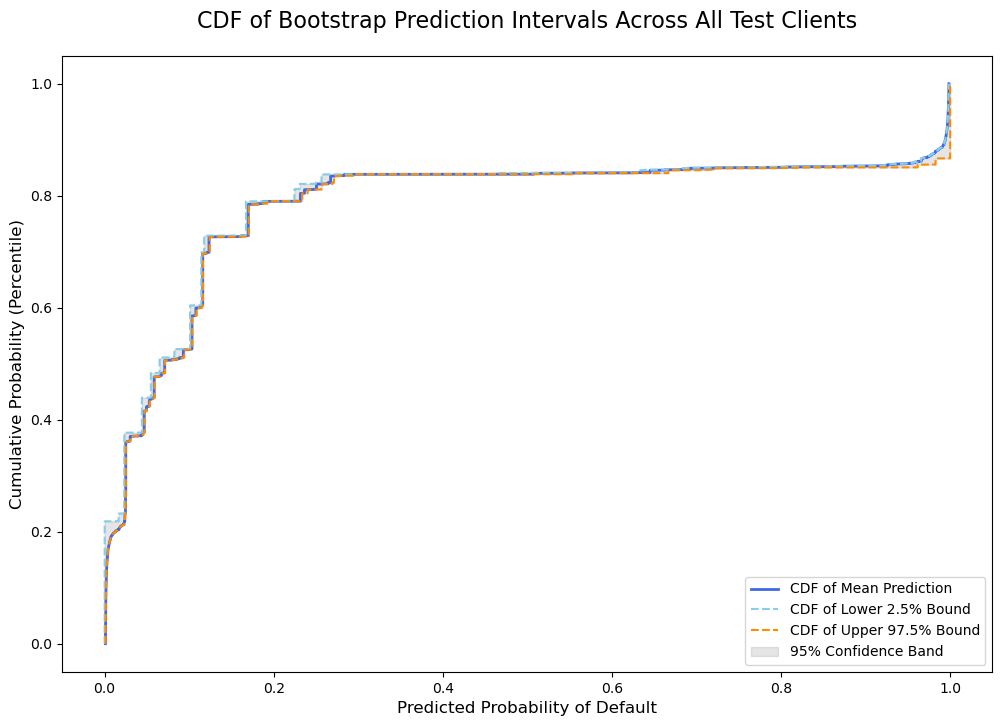

In [200]:
# We will plot the CDF for the mean predictions, and the lower/upper bounds
mean_probs_sorted = np.sort(test['xgb_venn_ivap'])  # or 'lr_venn_cvap' for Logistic Regression
lower_bounds_sorted = np.sort(test['xgb_p0_ivap'])
upper_bounds_sorted = np.sort(test['xgb_p1_ivap'])

# The y-axis for a CDF is the percentile, from 0 to 1
y_axis = np.linspace(0, 1, len(test))

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the three CDFs
ax.plot(mean_probs_sorted, y_axis, label='CDF of Mean Prediction', color='royalblue', linewidth=2)
ax.plot(lower_bounds_sorted, y_axis, label='CDF of Lower 2.5% Bound', color='skyblue', linestyle='--')
ax.plot(upper_bounds_sorted, y_axis, label='CDF of Upper 97.5% Bound', color='darkorange', linestyle='--')

# Add shading to represent the 95% confidence interval band
ax.fill_betweenx(y_axis, lower_bounds_sorted, upper_bounds_sorted, color='gray', alpha=0.2, label='95% Confidence Band')

ax.set_title('CDF of Bootstrap Prediction Intervals Across All Test Clients', fontsize=16, pad=20)
ax.set_xlabel('Predicted Probability of Default', fontsize=12)
ax.set_ylabel('Cumulative Probability (Percentile)', fontsize=12)
ax.legend(loc='lower right')
plt.show()
